In [1]:
import polars as pl
from polars.exceptions import ColumnNotFoundError
import numpy as np
import ast
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'Europe/Moscow'

from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import pickle
from tqdm.notebook import tqdm
from itertools import product

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, root_mean_squared_error

from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

from bot.analysis.backtesting import backtest, select_cols_1tf
from bot.utils.pair_trading import make_df_from_orderbooks, make_trunc_df, create_zscore_df
from bot.analysis.strategy_analysis import analyze_strategy
from bot.utils.files import load_config

In [2]:
def get_coins_info(token_1, token_2):
    dp_1 = float(coin_information['bybit_linear'][token_1 + '_USDT']['qty_step'])
    ps_1 = int(coin_information['bybit_linear'][token_1 + '_USDT']['price_scale'])
    dp_2 = float(coin_information['bybit_linear'][token_2 + '_USDT']['qty_step'])
    ps_2 = int(coin_information['bybit_linear'][token_2 + '_USDT']['price_scale'])

    return dp_1, dp_2, ps_1, ps_2

In [3]:
def run_test(df, wind, in_, out_, open_method, dist_in=None, dist_out=None):
    if dist_in is None:
        dist_in = 0.0
    if dist_out is None:
        dist_out = 0.0
    
    cols = ['time', 'ts', token_1, f'{token_1}_size', f'{token_1}_bid_price', f'{token_1}_ask_price',
                        f'{token_1}_bid_size', f'{token_1}_ask_size', token_2, f'{token_2}_size',
                        f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
                        f'spread_{wind}_{tf}', f'spread_mean_{wind}_{tf}', f'spread_std_{wind}_{tf}', f'z_score_{wind}_{tf}']

    tdf = df.select(cols).rename({f'z_score_{wind}_{tf}': 'z_score', f'spread_{wind}_{tf}': 'spread',
                f'spread_mean_{wind}_{tf}': 'spread_mean', f'spread_std_{wind}_{tf}': 'spread_std'}).drop_nulls()

    trades_df = backtest(tdf, token_1, token_2, dp_1, dp_2,
            thresh_low_in=-in_, thresh_low_out=-out_, thresh_high_in=in_, thresh_high_out=out_,
            long_possible=True, short_possible=True,
            balance=100, order_size=50, qty_method=qty_method, std_1=std_1, std_2=std_2,
            fee_rate=0.001, sl_std=sl_std, sl_dist=1.0, sl_method='leave',
            sl_seconds = 60, open_method=open_method, close_method=close_method, 
            leverage=leverage, dist_in=dist_in, dist_out=dist_out, force_close=False,
            verbose=0)

    if trades_df.height > 1:
        metrics = analyze_strategy(trades_df, start_date=valid_time, end_date=end_date, initial_balance=100.0)
        return tdf, trades_df, metrics
    else:
        return tdf, pl.DataFrame(), dict()

In [4]:
all_pairs = pl.read_parquet('./data/pair_selection/all_pairs.parquet')
all_pairs.height

1475

In [5]:
all_pairs.filter(
    ((pl.col('coin1') == 'EIGEN') & (pl.col('coin2') == 'WIF'))
)

shape: (1, 24)
┌───────┬───────┬──────────┬──────────┬───┬──────────┬──────────┬─────────┬─────────┐
│ coin1 ┆ coin2 ┆ dist     ┆ std      ┆ … ┆ coin1_ET ┆ coin2_ET ┆ coin1_S ┆ coin2_S │
│ ---   ┆ ---   ┆ ---      ┆ ---      ┆   ┆ H        ┆ H        ┆ OL      ┆ OL      │
│ str   ┆ str   ┆ f64      ┆ f64      ┆   ┆ ---      ┆ ---      ┆ ---     ┆ ---     │
│       ┆       ┆          ┆          ┆   ┆ f64      ┆ f64      ┆ f64     ┆ f64     │
╞═══════╪═══════╪══════════╪══════════╪═══╪══════════╪══════════╪═════════╪═════════╡
│ EIGEN ┆ WIF   ┆ 2.518214 ┆ 0.185007 ┆ … ┆ 0.731969 ┆ 0.769901 ┆ 0.72563 ┆ 0.81884 │
│       ┆       ┆          ┆          ┆   ┆          ┆          ┆ 5       ┆ 6       │
└───────┴───────┴──────────┴──────────┴───┴──────────┴──────────┴─────────┴─────────┘

In [6]:
config = load_config('./bot/config/config.yaml')

valid_time = config['valid_time']
end_time = config['end_time']
search_space = config['search_space']
pairs_file = config['token_pairs_file']

with open("./data/coin_information.pkl", "rb") as f:
    coin_information = pickle.load(f)

token_pairs = []
with open(pairs_file, 'r') as file:
    for line in file:
        a, b = line.strip().split()
        token_pairs.append((a, b))

In [7]:
leverage = 2

tf = '1h'
winds = np.array([48, 64, 72, 96])
in_params = (2.25, 2.0, 1.8)
out_params = (0.0, 0.25, )
spr_method = 'lr'

qty_method = 'usdt_neutral'
open_method = 'direct'
close_method = 'direct'
dist_in = 0
dist_out = 0

sl_std = 5.0

In [8]:
metrics_arr = []

s_len = len(winds) * len(in_params) * len(out_params) * len(token_pairs)
all_lists = [winds, in_params, out_params]

with tqdm(total=s_len, desc="Обработка", unit="iter") as progress_bar:
    for token_1, token_2 in token_pairs:
        dp_1, dp_2, ps_1, ps_2 = get_coins_info(token_1, token_2)

        pair_stats = all_pairs.filter((pl.col('coin1') == token_1) & (pl.col('coin2') == token_2))
        if pair_stats.height > 0:
            std_1 = pair_stats['std_1'][0]
            std_2 = pair_stats['std_2'][0]
        else:
            print(token_1, token_2, 'No Stats Data!')

        filepath = f'./data/pair_backtest/{token_1}_{token_2}_1h_{spr_method}.parquet'
        try:
            df = pl.read_parquet(filepath, low_memory=True, rechunk=True, use_pyarrow=True)
            end_date = df['time'][-1]
        except FileNotFoundError:
            print(f'FileNotFoundError!: {filepath}')
            continue

        for wind, in_, out_ in product(*all_lists):
            progress_bar.update(1)
            tdf, trades_df, metrics = run_test(df, wind, in_, out_, open_method='direct', dist_in=None, dist_out=None)

            if metrics:
                metrics_arr.append({
                    'token_1': token_1, 'token_2': token_2, 'tf': tf, 'wind': wind, 'spr_method': spr_method,
                    'open_method': open_method, 'close_method': close_method, 'qty_method': qty_method,
                    'thresh_in': in_, 'thresh_out': out_, 'dist_in': dist_in, 'dist_out': dist_out,
                    'n_trades': metrics['n_trades'], 'duration_avg': metrics['duration_avg'],
                    'stop_losses': metrics['stop_losses'], 'liquidations': metrics['liquidations'],
                    'profit': metrics['profit'], 'profit_ratio': metrics['profit_ratio'],
                    'max_profit': metrics['max_profit'], 'max_drawdown': metrics['max_drawdown'],
                    'max_loss': metrics['max_loss'], 'avg_profit': metrics['avg_profit'],
                    'profit_std': metrics['profit_std']})

mass_output = pl.DataFrame(metrics_arr).sort(by='profit', descending=True)

Обработка:   0%|          | 0/1872 [00:00<?, ?iter/s]

In [24]:
res_df = mass_output.group_by('token_1', 'token_2').agg(
            pl.col('profit').mean().round(2).alias('avg_profit'),
            pl.col('profit').std().round(2).alias('profit_std'),
            pl.col('profit_ratio').mean().round(2).alias('avg_pr_ratio'),
            pl.col('max_loss').min().round(2).alias('max_loss'),
        ).filter(
            (pl.col('avg_profit') > 2.0) & (pl.col('avg_pr_ratio') > 0.25) & (pl.col('max_loss') > -5.0)
        )
token_pairs = []
for row in res_df.iter_rows(named=True):
    token_pairs.append((row['token_1'], row['token_2']))
len(token_pairs)

63

In [25]:
print(f'Метод расчёта спреда: {spr_method}')
print(f'Суммарный профит: {mass_output["profit"].sum():_.1f}$; средний профит: {mass_output["profit"].mean():.2f}$')
print(f'Количество стоп-лоссов: {mass_output["stop_losses"].sum():_}; максимальная просадка: {mass_output["max_drawdown"].min():.2f}$')
print('Количество пар, торгуемых в плюс:', len(token_pairs))

Метод расчёта спреда: lr
Суммарный профит: 10_223.0$; средний профит: 5.51$
Количество стоп-лоссов: 802; максимальная просадка: -11.44$
Количество пар, торгуемых в плюс: 63


In [26]:
qty_methods = ('usdt_neutral', 'vol_neutral')
open_methods = ('direct', 'reverse_static', 'reverse_dynamic')
close_methods = ('direct', 'fix')

dist_in_params = (0.0, 0.1, 0.25, 0.5, 0.75, 1.0)
dist_out_params = (0.0, 0.1, 0.25, 0.5)

sl_std = 6.0

In [27]:
metrics_arr = []
processed_pairs = []

s_len = len(winds) * len(in_params) * len(out_params) * len(token_pairs) * len(open_methods) * len(dist_in_params)
all_lists = [winds, in_params, out_params, open_methods, dist_in_params]

with tqdm(total=s_len, desc="Обработка", unit="iter") as progress_bar:
    for token_1, token_2 in token_pairs:
        dp_1, dp_2, ps_1, ps_2 = get_coins_info(token_1, token_2)
        pair_stats = all_pairs.filter((pl.col('coin1') == token_1) & (pl.col('coin2') == token_2))
        if pair_stats.height > 0:
            std_1 = pair_stats['std_1'][0]
            std_2 = pair_stats['std_2'][0]
        else:
            print(token_1, token_2, 'No Stats Data!')

        filepath = f'./data/pair_backtest/{token_1}_{token_2}_1h_{spr_method}.parquet'
        try:
            df = pl.read_parquet(filepath, low_memory=True, rechunk=True, use_pyarrow=True)
            end_date = df['time'][-1]
        except FileNotFoundError:
            print(f'FileNotFoundError!: {filepath}')
            continue

        for wind, in_, out_, open_method, dist_in in product(*all_lists):
            progress_bar.update(1)
            if open_method == 'direct':
                dist_in, dist_out = 0, 0
                
                if (token_1, token_2, wind, open_method, in_, out_) in processed_pairs:
                    continue
            processed_pairs.append((token_1, token_2, wind, open_method, in_, out_))
            
            tdf, trades_df, metrics = run_test(df, wind, in_, out_, open_method=open_method, dist_in=dist_in, dist_out=dist_out)

            if metrics:
                metrics_arr.append({
                    'token_1': token_1, 'token_2': token_2, 'tf': tf, 'wind': wind, 'spr_method': spr_method,
                    'open_method': open_method, 'close_method': close_method, 'qty_method': qty_method,
                    'thresh_in': in_, 'thresh_out': out_, 'dist_in': dist_in, 'dist_out': dist_out,
                    'n_trades': metrics['n_trades'], 'duration_avg': metrics['duration_avg'],
                    'stop_losses': metrics['stop_losses'], 'liquidations': metrics['liquidations'],
                    'profit': metrics['profit'], 'profit_ratio': metrics['profit_ratio'],
                    'max_profit': metrics['max_profit'], 'max_drawdown': metrics['max_drawdown'],
                    'max_loss': metrics['max_loss'], 'avg_profit': metrics['avg_profit'],
                    'profit_std': metrics['profit_std']})

filtered_output = pl.DataFrame(metrics_arr).sort(by='profit', descending=True)

Обработка:   0%|          | 0/27216 [00:00<?, ?iter/s]

In [28]:
# Результаты для конкретных пар на общем тесте
res_df = filtered_output.group_by('token_1', 'token_2').agg(
            pl.col('profit').sum().round(2).alias('sum_profit'),        
            pl.col('profit').mean().round(2).alias('avg_profit'),
            pl.col('profit').std().round(2).alias('profit_std'),
            pl.col('max_loss').min().round(2).alias('max_loss'),
            pl.col('max_drawdown').mean().round(2).alias('avg_drawdown'),
            pl.col('max_drawdown').min().round(2).alias('max_drawdown'),
            pl.col('profit_ratio').mean().round(2).alias('avg_pr_ratio'),
            pl.col('stop_losses').mean().round(2).alias('stop_losses'),
            pl.col('n_trades').mean().round(2).alias('avg_trades'),
        ).sort('sum_profit', descending=True)
res_df

shape: (63, 11)
┌─────────┬─────────┬─────────┬─────────┬───┬─────────┬─────────┬─────────┬─────────┐
│ token_1 ┆ token_2 ┆ sum_pro ┆ avg_pro ┆ … ┆ max_dra ┆ avg_pr_ ┆ stop_lo ┆ avg_tra │
│ ---     ┆ ---     ┆ fit     ┆ fit     ┆   ┆ wdown   ┆ ratio   ┆ sses    ┆ des     │
│ str     ┆ str     ┆ ---     ┆ ---     ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│         ┆         ┆ f64     ┆ f64     ┆   ┆ f64     ┆ f64     ┆ f64     ┆ f64     │
╞═════════╪═════════╪═════════╪═════════╪═══╪═════════╪═════════╪═════════╪═════════╡
│ EIGEN   ┆ PENDLE  ┆ 3914.48 ┆ 13.05   ┆ … ┆ -3.63   ┆ 2.27    ┆ 0.0     ┆ 4.75    │
│ INJ     ┆ PENDLE  ┆ 2952.32 ┆ 10.85   ┆ … ┆ -2.58   ┆ 1.83    ┆ 0.0     ┆ 5.32    │
│ DOT     ┆ PENDLE  ┆ 2855.24 ┆ 9.91    ┆ … ┆ -1.7    ┆ 1.77    ┆ 0.0     ┆ 4.39    │
│ RUNE    ┆ WIF     ┆ 2552.47 ┆ 8.29    ┆ … ┆ -4.81   ┆ 1.51    ┆ 0.0     ┆ 5.61    │
│ TIA     ┆ TON     ┆ 2526.23 ┆ 11.7    ┆ … ┆ -4.72   ┆ 1.93    ┆ 0.0     ┆ 4.56    │
│ …       ┆ …       ┆ …       ┆ …       ┆ … ┆ …       ┆ …       ┆ …       ┆ …       │
│ S       ┆ THETA   ┆ 585.45  ┆ 2.09    ┆ … ┆ -5.65   ┆ 0.34    ┆ 0.26    ┆ 5.46    │
│ RUNE    ┆ STX     ┆ 553.83  ┆ 2.64    ┆ … ┆ -2.18   ┆ 0.5     ┆ 0.3     ┆ 4.31    │
│ ALGO    ┆ XLM     ┆ 497.56  ┆ 2.44    ┆ … ┆ -2.31   ┆ 0.42    ┆ 0.0     ┆ 4.07    │
│ ALGO    ┆ SEI     ┆ 478.06  ┆ 2.01    ┆ … ┆ -6.89   ┆ 0.31    ┆ 0.72    ┆ 4.38    │
│ MORPHO  ┆ XRP     ┆ 477.43  ┆ 2.32    ┆ … ┆ -4.35   ┆ 0.41    ┆ 0.0     ┆ 5.0     │
└─────────┴─────────┴─────────┴─────────┴───┴─────────┴─────────┴─────────┴─────────┘

In [44]:
tf_df = filtered_output.group_by('wind', 'thresh_in', 'thresh_out', 'dist_in', 'open_method').agg(
    pl.col('profit').sum().round(2).alias('sum_profit'),
    pl.col('profit').mean().round(2).alias('avg_profit'),
    pl.col('max_loss').min().round(2).alias('max_loss'),
    pl.col('max_drawdown').mean().round(2).alias('avg_drawdown'),
    pl.col('max_drawdown').min().round(2).alias('max_drawdown'),
    pl.col('profit_ratio').mean().round(2).alias('avg_pr_ratio'),
    pl.col('stop_losses').mean().round(2).alias('stop_losses'),
    pl.col('n_trades').mean().round(2).alias('avg_trades'),
    pl.col('n_trades').sum().round(2).alias('trades'),
).sort(['max_loss', 'sum_profit'], descending=[True, True]).filter(pl.col('sum_profit') > 120)
tf_df.head(10)

shape: (10, 14)
┌──────┬──────────┬──────────┬─────────┬───┬──────────┬──────────┬─────────┬────────┐
│ wind ┆ thresh_i ┆ thresh_o ┆ dist_in ┆ … ┆ avg_pr_r ┆ stop_los ┆ avg_tra ┆ trades │
│ ---  ┆ n        ┆ ut       ┆ ---     ┆   ┆ atio     ┆ ses      ┆ des     ┆ ---    │
│ i64  ┆ ---      ┆ ---      ┆ f64     ┆   ┆ ---      ┆ ---      ┆ ---     ┆ i64    │
│      ┆ f64      ┆ f64      ┆         ┆   ┆ f64      ┆ f64      ┆ f64     ┆        │
╞══════╪══════════╪══════════╪═════════╪═══╪══════════╪══════════╪═════════╪════════╡
│ 72   ┆ 2.25     ┆ 0.25     ┆ 0.5     ┆ … ┆ 0.97     ┆ 0.1      ┆ 2.8     ┆ 115    │
│ 72   ┆ 1.8      ┆ 0.25     ┆ 1.0     ┆ … ┆ 0.78     ┆ 0.08     ┆ 2.74    ┆ 104    │
│ 48   ┆ 2.25     ┆ 0.0      ┆ 0.1     ┆ … ┆ 0.78     ┆ 0.11     ┆ 5.11    ┆ 322    │
│ 48   ┆ 2.25     ┆ 0.25     ┆ 0.25    ┆ … ┆ 0.76     ┆ 0.1      ┆ 3.9     ┆ 238    │
│ 48   ┆ 2.25     ┆ 0.0      ┆ 0.25    ┆ … ┆ 0.59     ┆ 0.08     ┆ 3.97    ┆ 242    │
│ 64   ┆ 2.0      ┆ 0.0      ┆ 0.75    ┆ … ┆ 0.74     ┆ 0.05     ┆ 3.02    ┆ 130    │
│ 64   ┆ 2.0      ┆ 0.0      ┆ 0.75    ┆ … ┆ 0.67     ┆ 0.02     ┆ 3.02    ┆ 130    │
│ 72   ┆ 2.0      ┆ 0.25     ┆ 0.75    ┆ … ┆ 0.84     ┆ 0.1      ┆ 2.8     ┆ 115    │
│ 72   ┆ 2.0      ┆ 0.0      ┆ 0.75    ┆ … ┆ 0.77     ┆ 0.1      ┆ 2.81    ┆ 118    │
│ 48   ┆ 2.0      ┆ 0.25     ┆ 0.75    ┆ … ┆ 0.67     ┆ 0.07     ┆ 3.0     ┆ 129    │
└──────┴──────────┴──────────┴─────────┴───┴──────────┴──────────┴─────────┴────────┘

In [30]:
filtered_output.group_by('token_2').agg(
        pl.col('stop_losses').mean().round(2).alias('stop_losses'),
    ).sort('stop_losses', descending=True)[0:10]

shape: (10, 2)
┌─────────┬─────────────┐
│ token_2 ┆ stop_losses │
│ ---     ┆ ---         │
│ str     ┆ f64         │
╞═════════╪═════════════╡
│ MANTA   ┆ 0.79        │
│ KAS     ┆ 0.59        │
│ ONDO    ┆ 0.49        │
│ DYDX    ┆ 0.45        │
│ SEI     ┆ 0.39        │
│ WCT     ┆ 0.34        │
│ ATOM    ┆ 0.33        │
│ THETA   ┆ 0.26        │
│ AERO    ┆ 0.14        │
│ STX     ┆ 0.13        │
└─────────┴─────────────┘

In [37]:
# Выкидываем все пары, показашие плохой результат, и сохраняем хорошие пары в файл
res_df = res_df.filter(
    (pl.col('avg_profit') > 2.0) & (pl.col('avg_pr_ratio') > 0.25) & (pl.col('max_loss') > -5.0)
)
res_df.sort(by='avg_pr_ratio', descending=True)

shape: (61, 11)
┌─────────┬─────────┬─────────┬─────────┬───┬─────────┬─────────┬─────────┬─────────┐
│ token_1 ┆ token_2 ┆ sum_pro ┆ avg_pro ┆ … ┆ max_dra ┆ avg_pr_ ┆ stop_lo ┆ avg_tra │
│ ---     ┆ ---     ┆ fit     ┆ fit     ┆   ┆ wdown   ┆ ratio   ┆ sses    ┆ des     │
│ str     ┆ str     ┆ ---     ┆ ---     ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│         ┆         ┆ f64     ┆ f64     ┆   ┆ f64     ┆ f64     ┆ f64     ┆ f64     │
╞═════════╪═════════╪═════════╪═════════╪═══╪═════════╪═════════╪═════════╪═════════╡
│ EIGEN   ┆ PENDLE  ┆ 3914.48 ┆ 13.05   ┆ … ┆ -3.63   ┆ 2.27    ┆ 0.0     ┆ 4.75    │
│ TIA     ┆ TON     ┆ 2526.23 ┆ 11.7    ┆ … ┆ -4.72   ┆ 1.93    ┆ 0.0     ┆ 4.56    │
│ INJ     ┆ PENDLE  ┆ 2952.32 ┆ 10.85   ┆ … ┆ -2.58   ┆ 1.83    ┆ 0.0     ┆ 5.32    │
│ DOT     ┆ PENDLE  ┆ 2855.24 ┆ 9.91    ┆ … ┆ -1.7    ┆ 1.77    ┆ 0.0     ┆ 4.39    │
│ ETHFI   ┆ ZRO     ┆ 1843.19 ┆ 8.61    ┆ … ┆ -3.2    ┆ 1.6     ┆ 0.0     ┆ 2.87    │
│ …       ┆ …       ┆ …       ┆ …       ┆ … ┆ …       ┆ …       ┆ …       ┆ …       │
│ ALGO    ┆ XLM     ┆ 497.56  ┆ 2.44    ┆ … ┆ -2.31   ┆ 0.42    ┆ 0.0     ┆ 4.07    │
│ ARKM    ┆ WCT     ┆ 607.69  ┆ 2.3     ┆ … ┆ -5.95   ┆ 0.41    ┆ 0.29    ┆ 5.25    │
│ MORPHO  ┆ XRP     ┆ 477.43  ┆ 2.32    ┆ … ┆ -4.35   ┆ 0.41    ┆ 0.0     ┆ 5.0     │
│ S       ┆ THETA   ┆ 585.45  ┆ 2.09    ┆ … ┆ -5.65   ┆ 0.34    ┆ 0.26    ┆ 5.46    │
│ ALGO    ┆ SEI     ┆ 478.06  ┆ 2.01    ┆ … ┆ -6.89   ┆ 0.31    ┆ 0.72    ┆ 4.38    │
└─────────┴─────────┴─────────┴─────────┴───┴─────────┴─────────┴─────────┴─────────┘

In [38]:
# Теперь для плюсовых пар ещё раз прогоним общий бектест для подбора наилучших параметров только на этих парах.
token_pairs = []
for row in res_df.iter_rows(named=True):
    token_pairs.append((row['token_1'], row['token_2']))
len(token_pairs)

61

In [39]:
tf_df.filter((pl.col('open_method') == 'reverse_static') & (pl.col('wind') == 64) & (pl.col('thresh_in') == 2.25))

shape: (8, 14)
┌──────┬──────────┬──────────┬─────────┬───┬──────────┬──────────┬─────────┬────────┐
│ wind ┆ thresh_i ┆ thresh_o ┆ dist_in ┆ … ┆ avg_pr_r ┆ stop_los ┆ avg_tra ┆ trades │
│ ---  ┆ n        ┆ ut       ┆ ---     ┆   ┆ atio     ┆ ses      ┆ des     ┆ ---    │
│ i64  ┆ ---      ┆ ---      ┆ f64     ┆   ┆ ---      ┆ ---      ┆ ---     ┆ i64    │
│      ┆ f64      ┆ f64      ┆         ┆   ┆ f64      ┆ f64      ┆ f64     ┆        │
╞══════╪══════════╪══════════╪═════════╪═══╪══════════╪══════════╪═════════╪════════╡
│ 64   ┆ 2.25     ┆ 0.25     ┆ 0.5     ┆ … ┆ 0.86     ┆ 0.02     ┆ 3.02    ┆ 130    │
│ 64   ┆ 2.25     ┆ 0.0      ┆ 0.5     ┆ … ┆ 0.75     ┆ 0.02     ┆ 3.02    ┆ 130    │
│ 64   ┆ 2.25     ┆ 0.0      ┆ 0.1     ┆ … ┆ 0.91     ┆ 0.08     ┆ 4.49    ┆ 283    │
│ 64   ┆ 2.25     ┆ 0.25     ┆ 0.25    ┆ … ┆ 0.91     ┆ 0.09     ┆ 3.68    ┆ 206    │
│ 64   ┆ 2.25     ┆ 0.0      ┆ 0.25    ┆ … ┆ 0.73     ┆ 0.09     ┆ 3.68    ┆ 206    │
│ 64   ┆ 2.25     ┆ 0.0      ┆ 0.0     ┆ … ┆ 0.97     ┆ 0.1      ┆ 5.13    ┆ 323    │
│ 64   ┆ 2.25     ┆ 0.25     ┆ 0.1     ┆ … ┆ 1.09     ┆ 0.11     ┆ 4.44    ┆ 280    │
│ 64   ┆ 2.25     ┆ 0.25     ┆ 0.0     ┆ … ┆ 1.14     ┆ 0.13     ┆ 5.02    ┆ 316    │
└──────┴──────────┴──────────┴─────────┴───┴──────────┴──────────┴─────────┴────────┘

In [40]:
tf_df.filter((pl.col('open_method') == 'reverse_static') & (pl.col('wind') == 64) & (pl.col('thresh_in') == 1.8))

shape: (12, 14)
┌──────┬──────────┬──────────┬─────────┬───┬──────────┬──────────┬─────────┬────────┐
│ wind ┆ thresh_i ┆ thresh_o ┆ dist_in ┆ … ┆ avg_pr_r ┆ stop_los ┆ avg_tra ┆ trades │
│ ---  ┆ n        ┆ ut       ┆ ---     ┆   ┆ atio     ┆ ses      ┆ des     ┆ ---    │
│ i64  ┆ ---      ┆ ---      ┆ f64     ┆   ┆ ---      ┆ ---      ┆ ---     ┆ i64    │
│      ┆ f64      ┆ f64      ┆         ┆   ┆ f64      ┆ f64      ┆ f64     ┆        │
╞══════╪══════════╪══════════╪═════════╪═══╪══════════╪══════════╪═════════╪════════╡
│ 64   ┆ 1.8      ┆ 0.25     ┆ 1.0     ┆ … ┆ 0.74     ┆ 0.03     ┆ 2.95    ┆ 115    │
│ 64   ┆ 1.8      ┆ 0.0      ┆ 1.0     ┆ … ┆ 0.62     ┆ 0.03     ┆ 2.95    ┆ 115    │
│ 64   ┆ 1.8      ┆ 0.0      ┆ 0.5     ┆ … ┆ 0.69     ┆ 0.06     ┆ 4.76    ┆ 300    │
│ 64   ┆ 1.8      ┆ 0.25     ┆ 0.75    ┆ … ┆ 0.74     ┆ 0.06     ┆ 3.59    ┆ 194    │
│ 64   ┆ 1.8      ┆ 0.0      ┆ 0.75    ┆ … ┆ 0.57     ┆ 0.06     ┆ 3.59    ┆ 194    │
│ …    ┆ …        ┆ …        ┆ …       ┆ … ┆ …        ┆ …        ┆ …       ┆ …      │
│ 64   ┆ 1.8      ┆ 0.25     ┆ 0.25    ┆ … ┆ 1.03     ┆ 0.14     ┆ 6.27    ┆ 395    │
│ 64   ┆ 1.8      ┆ 0.0      ┆ 0.0     ┆ … ┆ 0.96     ┆ 0.17     ┆ 8.57    ┆ 540    │
│ 64   ┆ 1.8      ┆ 0.0      ┆ 0.1     ┆ … ┆ 0.91     ┆ 0.17     ┆ 7.65    ┆ 482    │
│ 64   ┆ 1.8      ┆ 0.25     ┆ 0.0     ┆ … ┆ 1.19     ┆ 0.19     ┆ 8.11    ┆ 511    │
│ 64   ┆ 1.8      ┆ 0.25     ┆ 0.1     ┆ … ┆ 1.12     ┆ 0.19     ┆ 7.27    ┆ 458    │
└──────┴──────────┴──────────┴─────────┴───┴──────────┴──────────┴─────────┴────────┘

In [45]:
current_pairs = []
with open('./bot/config/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        current_pairs.append((a, b))

In [46]:
all_token_pairs = set(current_pairs + token_pairs)
len(all_token_pairs)

70

In [39]:
# with open('./data/token_pairs.txt', 'w') as file:
#     for pair in all_token_pairs:
#         file.write(f"{pair[0]} {pair[1]}\n")

============= LDO MORPHO =============
Волатильность. LDO: 0.0597, MORPHO: 0.0579. std_ratio: 1.0322
beta_1: 0.685, beta_2: 0.812; tls_beta: 0.536; cointegr: 0; hedge ratio: 2.12
dist. profit:  -3.9; ratio: -0.54; drawdown: -3.91; n_trades: 4; stop losses: 1
  lr. profit:   4.8; ratio:  0.87; drawdown: -0.76; n_trades: 8; stop losses: 0


============= OP WCT =============
Волатильность. OP: 0.0557, WCT: 0.0764. std_ratio: 0.7292
beta_1: 0.614, beta_2: 1.052; tls_beta: 1.758; cointegr: 0; hedge ratio: 1.14
dist. profit:  -4.5; ratio: -0.46; drawdown: -7.11; n_trades: 2; stop losses: 1
  lr. profit:   4.2; ratio:  0.54; drawdown: -4.21; n_trades: 4; stop losses: 0


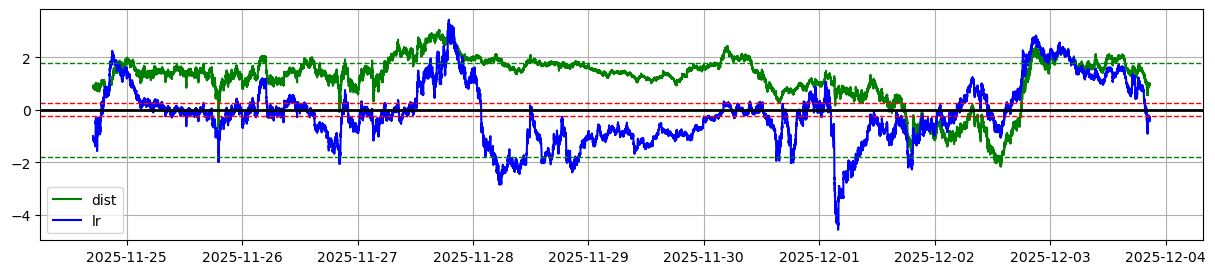

============= ATOM PENDLE =============
ACTIVE!
Волатильность. ATOM: 0.0416, PENDLE: 0.0543. std_ratio: 0.7664
beta_1: 1.109, beta_2: 0.715; tls_beta: 1.255; cointegr: 0; hedge ratio: 0.96
dist. profit: -17.0; ratio: -0.92; drawdown: -18.69; n_trades: 2; stop losses: 1
  lr. profit:   7.3; ratio:  1.42; drawdown: 0.0; n_trades: 3; stop losses: 0


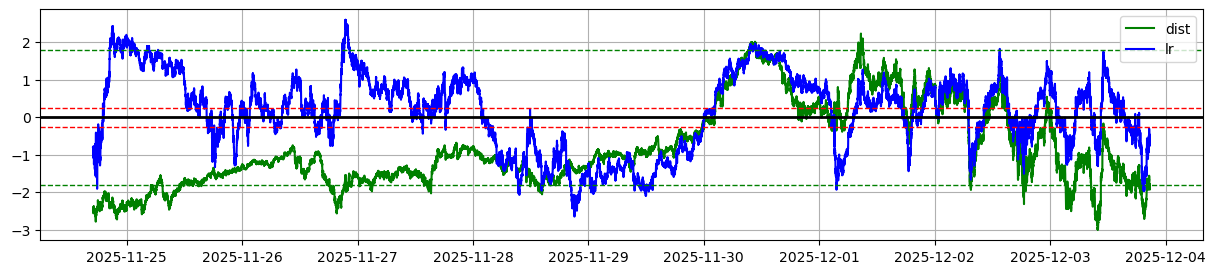

============= ATOM TON =============
ACTIVE!
Волатильность. ATOM: 0.0416, TON: 0.0358. std_ratio: 1.1633
beta_1: 0.970, beta_2: 0.960; tls_beta: 1.251; cointegr: 0; hedge ratio: 0.95
dist. profit:   7.2; ratio:  1.38; drawdown: -0.27; n_trades: 5; stop losses: 0
  lr. profit:   4.3; ratio:  0.86; drawdown: 0.0; n_trades: 2; stop losses: 0


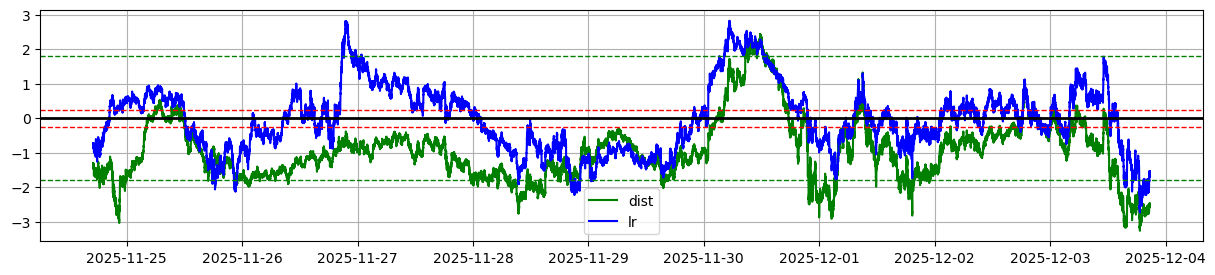

============= AERO ARB =============
ACTIVE!
Волатильность. AERO: 0.0679, ARB: 0.0579. std_ratio: 1.1724
beta_1: 0.450, beta_2: 1.168; tls_beta: 1.508; cointegr: 0; hedge ratio: 1.26
dist. profit:   7.1; ratio:  1.40; drawdown: 0.0; n_trades: 5; stop losses: 0
  lr. profit:   5.7; ratio:  1.13; drawdown: 0.0; n_trades: 5; stop losses: 0


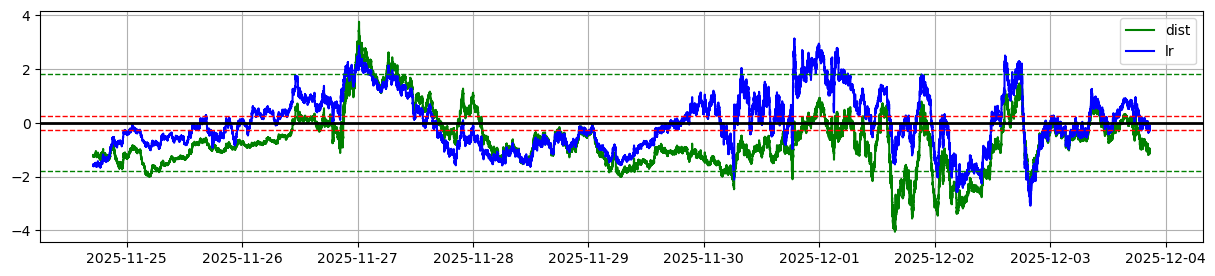

============= DRIFT ONDO =============
Волатильность. DRIFT: 0.0663, ONDO: 0.0437. std_ratio: 1.5188
beta_1: 0.675, beta_2: 0.924; tls_beta: 0.542; cointegr: 0; hedge ratio: 1.24
dist. profit:  17.1; ratio:  3.36; drawdown: 0.0; n_trades: 6; stop losses: 0
  lr. profit:   7.8; ratio:  1.44; drawdown: -0.5; n_trades: 6; stop losses: 0


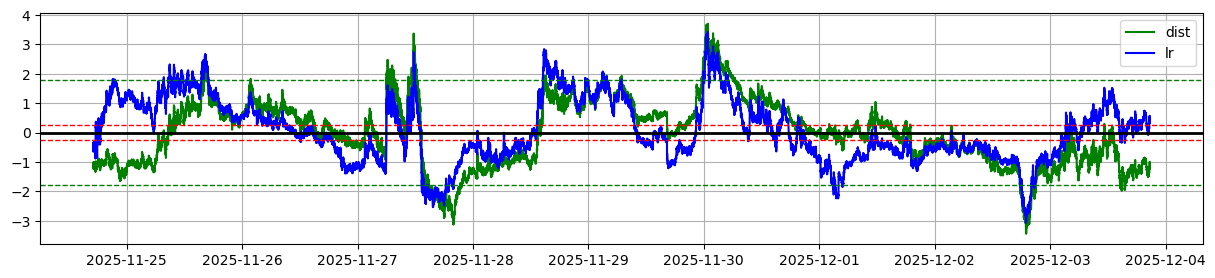

============= MANA PNUT =============
Волатильность. MANA: 0.0460, PNUT: 0.0641. std_ratio: 0.7171
beta_1: 1.201, beta_2: 0.638; tls_beta: 2.095; cointegr: 0; hedge ratio: 0.99
dist. profit:  -7.8; ratio: -0.83; drawdown: -7.84; n_trades: 2; stop losses: 1
  lr. profit:  11.5; ratio:  2.11; drawdown: -0.43; n_trades: 4; stop losses: 0


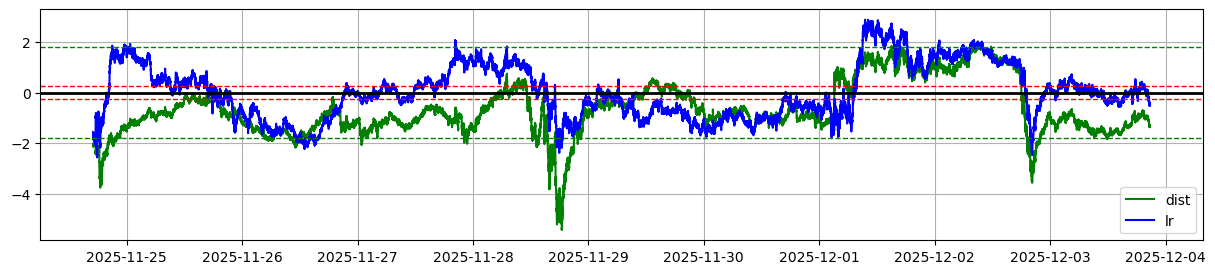

============= ARB PNUT =============
Волатильность. ARB: 0.0579, PNUT: 0.0641. std_ratio: 0.9035
beta_1: 0.537, beta_2: 1.028; tls_beta: 1.533; cointegr: 0; hedge ratio: 2.13
dist. profit:   2.8; ratio:  0.42; drawdown: -2.92; n_trades: 5; stop losses: 1
  lr. profit:   6.0; ratio:  0.94; drawdown: -2.31; n_trades: 7; stop losses: 0


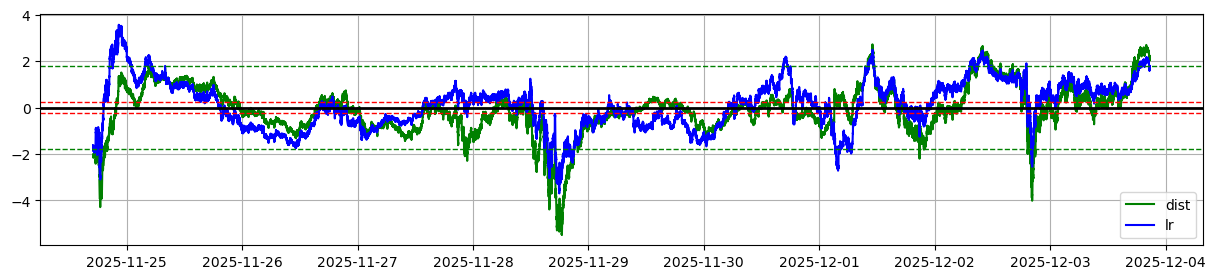

============= LDO XRP =============
Волатильность. LDO: 0.0597, XRP: 0.0356. std_ratio: 1.6764
beta_1: 0.819, beta_2: 0.911; tls_beta: 0.461; cointegr: 0; hedge ratio: 0.93
dist. profit:   1.3; ratio:  0.25; drawdown: -0.47; n_trades: 3; stop losses: 0
  lr. profit:   6.2; ratio:  1.12; drawdown: -0.8; n_trades: 6; stop losses: 0


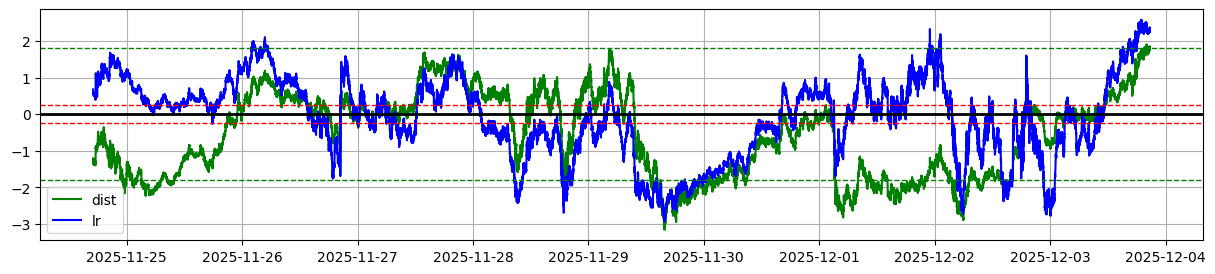

============= ENS PENDLE =============
Волатильность. ENS: 0.0464, PENDLE: 0.0543. std_ratio: 0.8548
beta_1: 0.699, beta_2: 1.165; tls_beta: 1.554; cointegr: 0; hedge ratio: 1.50
dist. profit:  -6.4; ratio: -0.61; drawdown: -8.19; n_trades: 2; stop losses: 0
  lr. profit:   2.4; ratio:  0.36; drawdown: -2.71; n_trades: 6; stop losses: 0


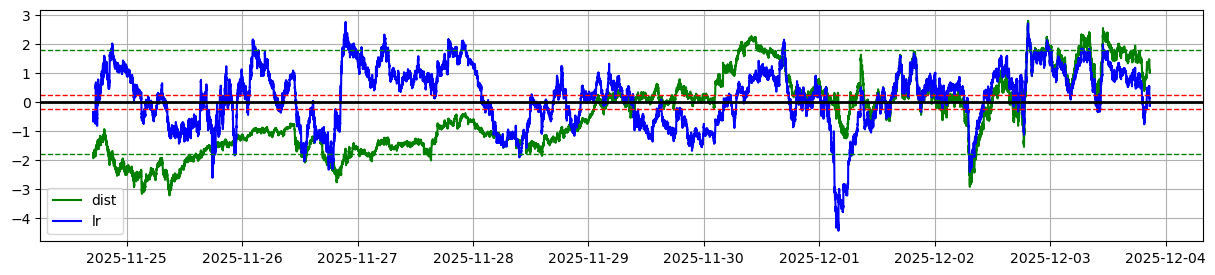

============= EIGEN OP =============
ACTIVE!
Волатильность. EIGEN: 0.0710, OP: 0.0557. std_ratio: 1.2736
beta_1: 0.538, beta_2: 1.395; tls_beta: 1.062; cointegr: 0; hedge ratio: 1.67
dist. profit:  -0.6; ratio: -0.10; drawdown: -1.86; n_trades: 2; stop losses: 0
  lr. profit:   6.1; ratio:  1.20; drawdown: 0.0; n_trades: 4; stop losses: 0


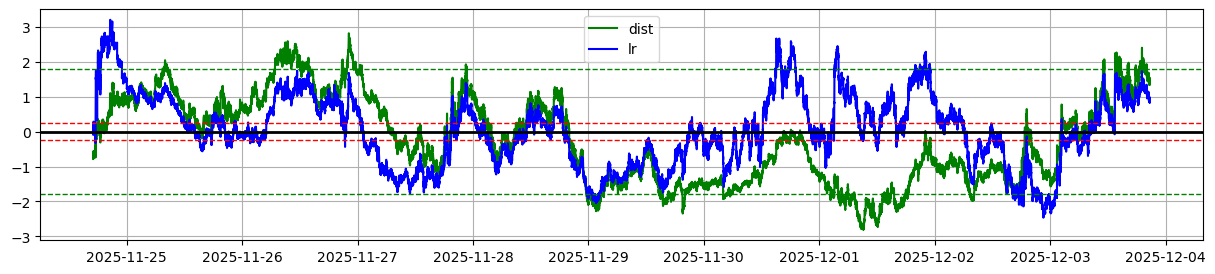

============= ALGO XLM =============
Волатильность. ALGO: 0.0466, XLM: 0.0421. std_ratio: 1.1066
beta_1: 1.490, beta_2: 0.598; tls_beta: 1.053; cointegr: 0; hedge ratio: 0.66
dist. profit:   3.3; ratio:  0.63; drawdown: -0.26; n_trades: 4; stop losses: 0
  lr. profit:  -0.1; ratio: -0.02; drawdown: -1.92; n_trades: 3; stop losses: 0


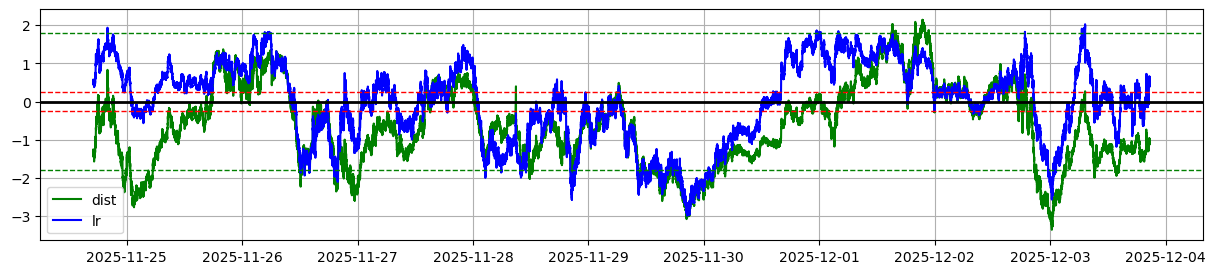

============= RUNE STX =============
ACTIVE!
Волатильность. RUNE: 0.0422, STX: 0.0471. std_ratio: 0.8962
beta_1: 0.653, beta_2: 1.428; tls_beta: 1.154; cointegr: 0; hedge ratio: 1.63
dist. profit:  -7.3; ratio: -0.79; drawdown: -7.61; n_trades: 3; stop losses: 2
  lr. profit:   3.0; ratio:  0.59; drawdown: 0.0; n_trades: 3; stop losses: 0


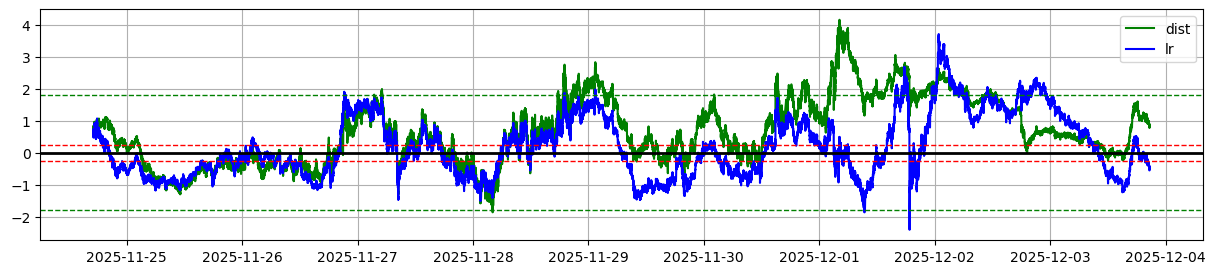

============= DOT RUNE =============
Волатильность. DOT: 0.0444, RUNE: 0.0422. std_ratio: 1.0516
beta_1: 0.905, beta_2: 0.830; tls_beta: 2.294; cointegr: 0; hedge ratio: 0.58
dist. profit:  -2.3; ratio: -0.34; drawdown: -2.8; n_trades: 2; stop losses: 1
  lr. profit:   3.8; ratio:  0.75; drawdown: 0.0; n_trades: 5; stop losses: 0


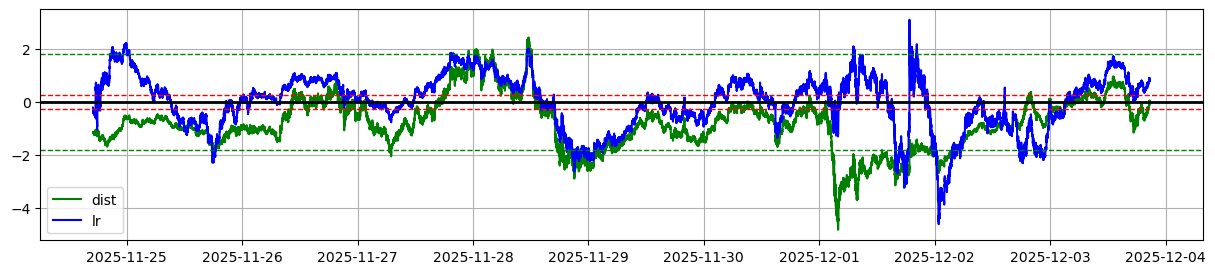

============= TIA TON =============
Волатильность. TIA: 0.0624, TON: 0.0358. std_ratio: 1.7446
beta_1: 0.846, beta_2: 1.099; tls_beta: 0.558; cointegr: 0; hedge ratio: 1.03
dist. profit:  12.2; ratio:  2.32; drawdown: 0.0; n_trades: 4; stop losses: 0
  lr. profit:   2.4; ratio:  0.33; drawdown: -3.6; n_trades: 3; stop losses: 0


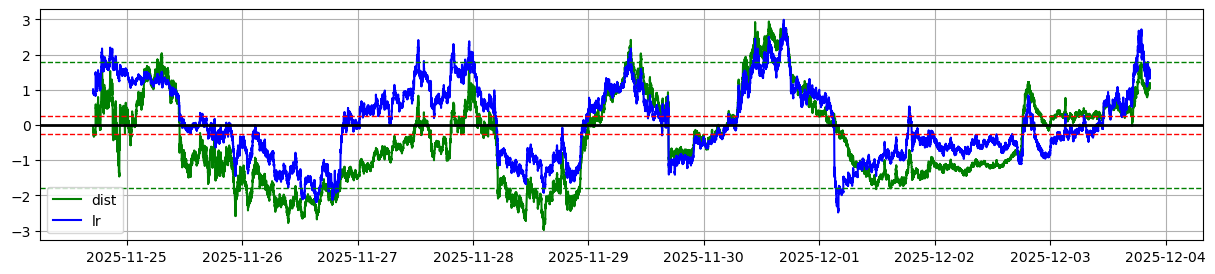

============= ADA AERO =============
Волатильность. ADA: 0.0403, AERO: 0.0679. std_ratio: 0.5929
beta_1: 0.950, beta_2: 0.544; tls_beta: 1.035; cointegr: 0; hedge ratio: 1.21
dist. profit:  -1.2; ratio: -0.16; drawdown: -3.87; n_trades: 3; stop losses: 1
  lr. profit:   2.6; ratio:  0.46; drawdown: -1.11; n_trades: 5; stop losses: 0


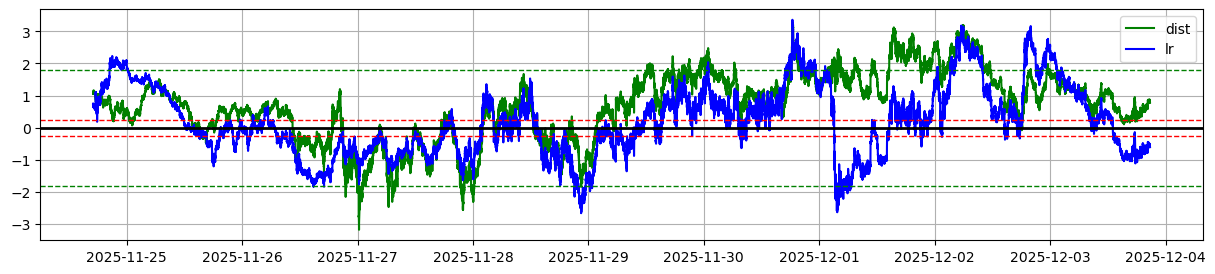

============= ADA IMX =============
Волатильность. ADA: 0.0403, IMX: 0.0580. std_ratio: 0.6941
beta_1: 0.749, beta_2: 0.980; tls_beta: 1.069; cointegr: 0; hedge ratio: 1.40
dist. profit:   4.9; ratio:  0.97; drawdown: 0.0; n_trades: 4; stop losses: 0
  lr. profit:   1.0; ratio:  0.17; drawdown: -1.75; n_trades: 5; stop losses: 0


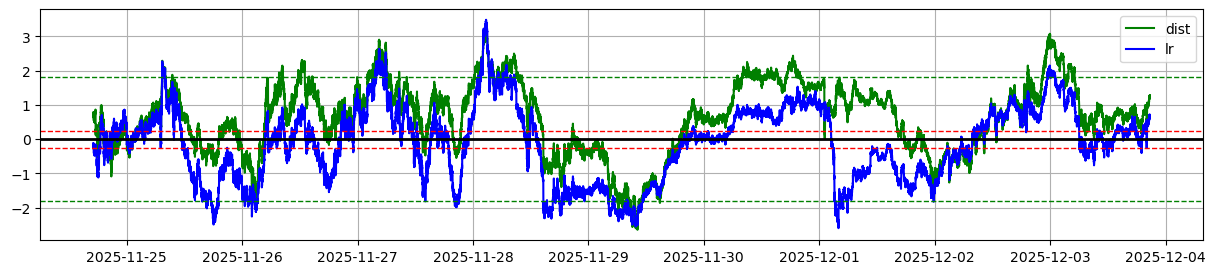

============= DOGE SEI =============
Волатильность. DOGE: 0.0459, SEI: 0.0563. std_ratio: 0.8150
beta_1: 1.420, beta_2: 0.434; tls_beta: 1.806; cointegr: 1; hedge ratio: 0.43
dist. profit:   6.4; ratio:  1.25; drawdown: -0.09; n_trades: 6; stop losses: 0
  lr. profit:   3.4; ratio:  0.68; drawdown: 0.0; n_trades: 5; stop losses: 0


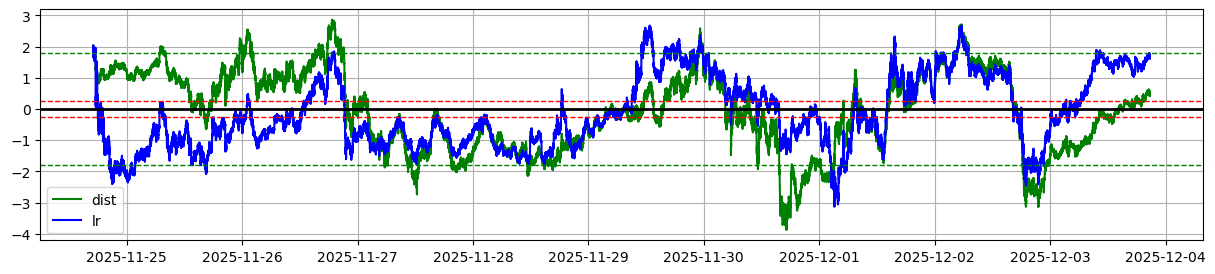

============= RUNE SUI =============
Волатильность. RUNE: 0.0422, SUI: 0.0485. std_ratio: 0.8704
beta_1: 1.206, beta_2: 0.619; tls_beta: 0.776; cointegr: 0; hedge ratio: 0.39
dist. profit:   0.4; ratio:  0.06; drawdown: -4.57; n_trades: 5; stop losses: 1
  lr. profit:   9.1; ratio:  1.36; drawdown: -2.41; n_trades: 5; stop losses: 0


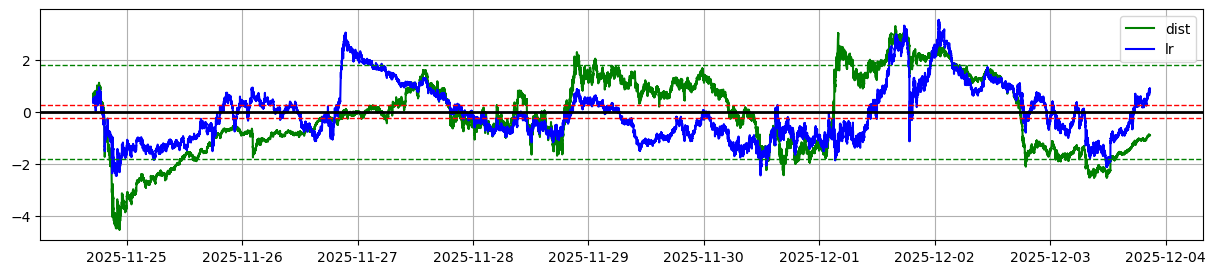

============= ARB ARKM =============
Волатильность. ARB: 0.0579, ARKM: 0.0603. std_ratio: 0.9611
beta_1: 0.945, beta_2: 0.837; tls_beta: 0.945; cointegr: 0; hedge ratio: 0.97
dist. profit:  -1.2; ratio: -0.17; drawdown: -3.49; n_trades: 6; stop losses: 1
  lr. profit:   5.2; ratio:  1.00; drawdown: -0.36; n_trades: 10; stop losses: 0


============= DYDX JUP =============
Волатильность. DYDX: 0.0573, JUP: 0.0513. std_ratio: 1.1172
beta_1: 0.582, beta_2: 1.464; tls_beta: 0.670; cointegr: 0; hedge ratio: 1.65
dist. profit:  -2.6; ratio: -0.33; drawdown: -4.9; n_trades: 3; stop losses: 1
  lr. profit:   2.9; ratio:  0.54; drawdown: -0.63; n_trades: 4; stop losses: 0


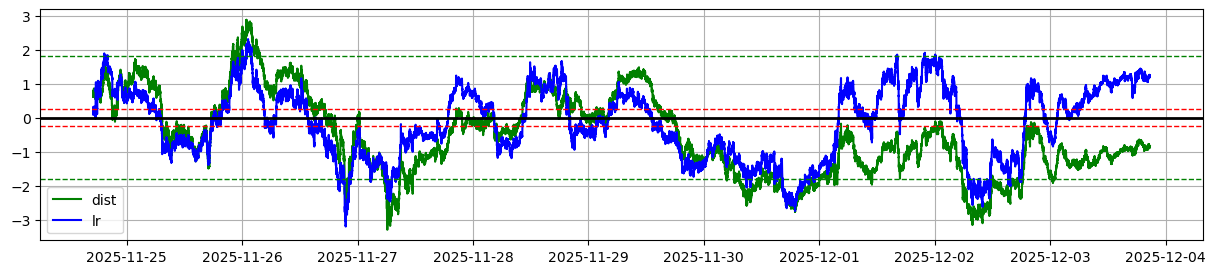

============= EIGEN PENDLE =============
ACTIVE!
Волатильность. EIGEN: 0.0710, PENDLE: 0.0543. std_ratio: 1.3077
beta_1: 1.102, beta_2: 0.673; tls_beta: 0.570; cointegr: 0; hedge ratio: 0.76
dist. profit:   9.1; ratio:  1.80; drawdown: 0.0; n_trades: 3; stop losses: 0
  lr. profit:  14.4; ratio:  2.42; drawdown: -1.19; n_trades: 6; stop losses: 0


============= IMX WLD =============
Волатильность. IMX: 0.0580, WLD: 0.0714. std_ratio: 0.8130
beta_1: 1.327, beta_2: 0.531; tls_beta: 0.913; cointegr: 1; hedge ratio: 0.64
dist. profit:   7.4; ratio:  1.45; drawdown: 0.0; n_trades: 6; stop losses: 0
  lr. profit:   5.9; ratio:  1.07; drawdown: -0.82; n_trades: 8; stop losses: 0


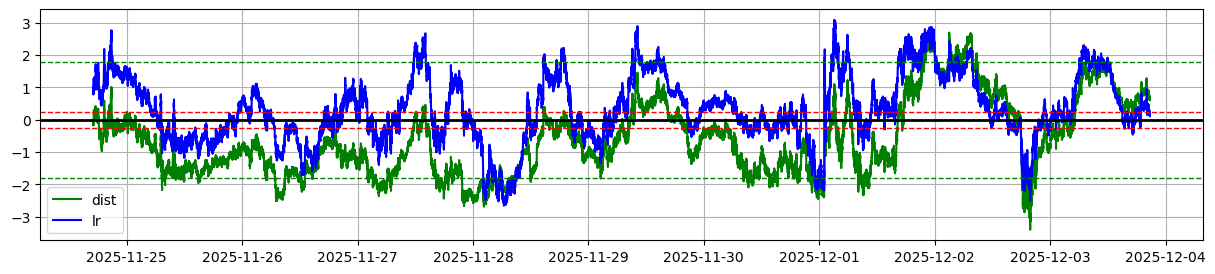

============= DRIFT OP =============
ACTIVE!
Волатильность. DRIFT: 0.0663, OP: 0.0557. std_ratio: 1.1901
beta_1: 0.710, beta_2: 0.843; tls_beta: 0.795; cointegr: 0; hedge ratio: 1.46
dist. profit:   8.3; ratio:  1.65; drawdown: 0.0; n_trades: 4; stop losses: 0
  lr. profit:   9.0; ratio:  1.78; drawdown: 0.0; n_trades: 6; stop losses: 0


============= AERO PENDLE =============
ACTIVE!
Волатильность. AERO: 0.0679, PENDLE: 0.0543. std_ratio: 1.2512
beta_1: 1.118, beta_2: 0.370; tls_beta: 0.594; cointegr: 0; hedge ratio: 0.32
dist. profit:  -6.4; ratio: -0.60; drawdown: -8.56; n_trades: 2; stop losses: 0
  lr. profit:   7.4; ratio:  1.48; drawdown: 0.0; n_trades: 3; stop losses: 0


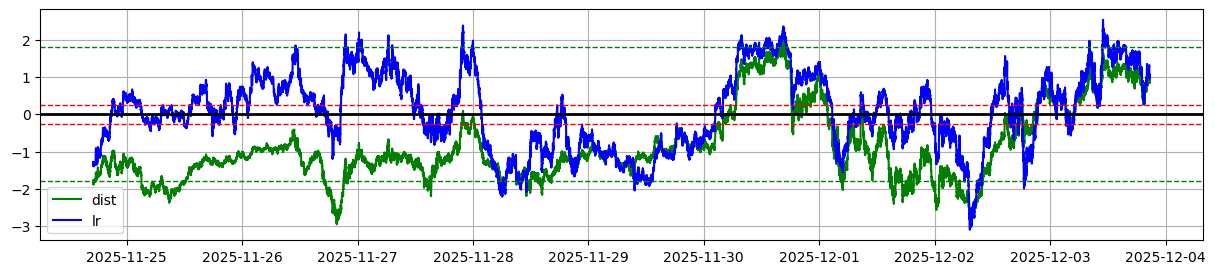

============= IMX XLM =============
Волатильность. IMX: 0.0580, XLM: 0.0421. std_ratio: 1.3779
beta_1: 0.523, beta_2: 1.005; tls_beta: 1.063; cointegr: 0; hedge ratio: 1.13
dist. profit:  10.2; ratio:  2.04; drawdown: 0.0; n_trades: 7; stop losses: 0
  lr. profit:   3.9; ratio:  0.74; drawdown: -0.19; n_trades: 4; stop losses: 0


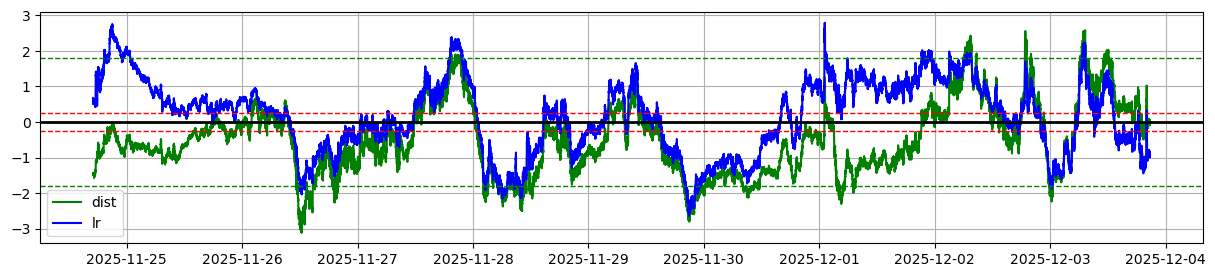

============= INJ ORDI =============
ACTIVE!
Волатильность. INJ: 0.0564, ORDI: 0.0677. std_ratio: 0.8331
beta_1: 1.027, beta_2: 0.944; tls_beta: 1.219; cointegr: 1; hedge ratio: 1.04
dist. profit:   6.0; ratio:  1.17; drawdown: 0.0; n_trades: 5; stop losses: 0
  lr. profit:   5.1; ratio:  1.01; drawdown: 0.0; n_trades: 5; stop losses: 0


============= DOT ONDO =============
Волатильность. DOT: 0.0444, ONDO: 0.0437. std_ratio: 1.0170
beta_1: 0.633, beta_2: 1.425; tls_beta: 1.767; cointegr: 0; hedge ratio: 1.50
dist. profit:   1.0; ratio:  0.18; drawdown: -0.49; n_trades: 3; stop losses: 0
  lr. profit:   0.4; ratio:  0.06; drawdown: -4.13; n_trades: 6; stop losses: 1


============= ARKM STX =============
Волатильность. ARKM: 0.0603, STX: 0.0471. std_ratio: 1.2791
beta_1: 1.145, beta_2: 0.717; tls_beta: 1.032; cointegr: 0; hedge ratio: 0.65
dist. profit:   6.1; ratio:  1.22; drawdown: 0.0; n_trades: 8; stop losses: 0
  lr. profit:   3.3; ratio:  0.66; drawdown: 0.0; n_trades: 6; stop losses: 0


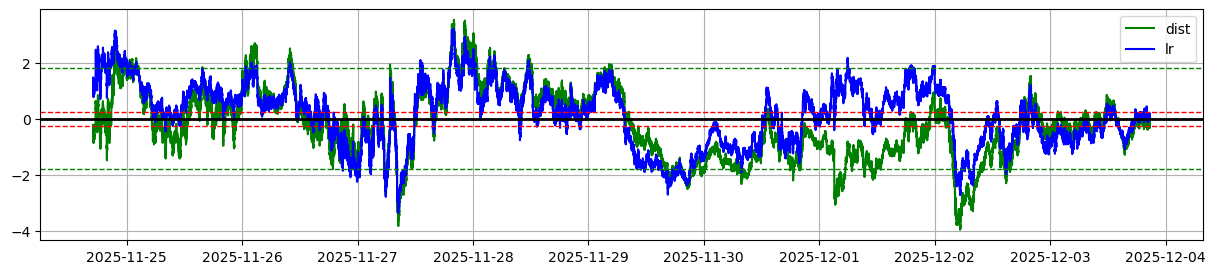

============= ETHFI ZRO =============
Волатильность. ETHFI: 0.0669, ZRO: 0.0486. std_ratio: 1.3750
beta_1: 0.753, beta_2: 0.937; tls_beta: 0.634; cointegr: 0; hedge ratio: 2.10
dist. profit:   7.8; ratio:  1.49; drawdown: 0.0; n_trades: 3; stop losses: 0
  lr. profit:   4.4; ratio:  0.82; drawdown: 0.0; n_trades: 2; stop losses: 0


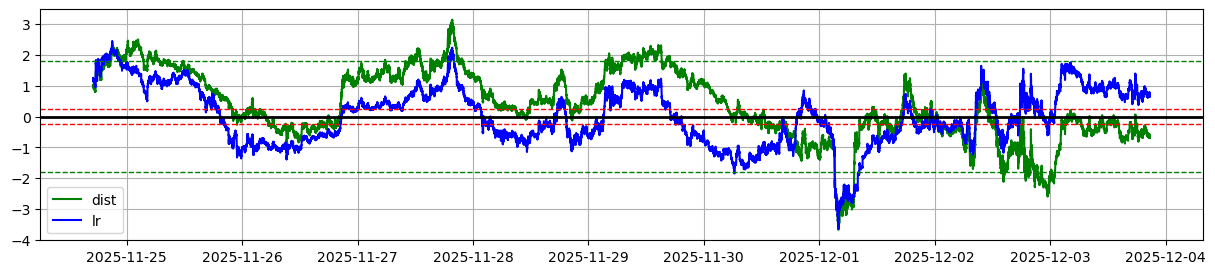

============= EIGEN RENDER =============
Волатильность. EIGEN: 0.0710, RENDER: 0.0539. std_ratio: 1.3176
beta_1: 1.014, beta_2: 0.708; tls_beta: 0.618; cointegr: 0; hedge ratio: 0.79
dist. profit:  -2.0; ratio: -0.23; drawdown: -6.08; n_trades: 3; stop losses: 1
  lr. profit:  -6.1; ratio: -0.57; drawdown: -10.0; n_trades: 6; stop losses: 0


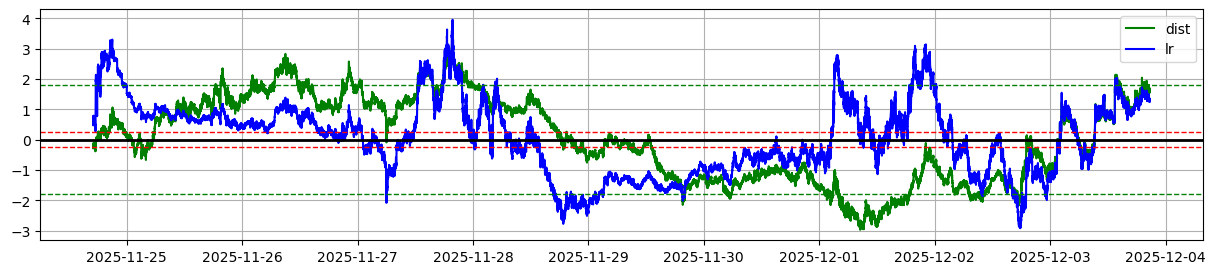

============= IMX XTZ =============
ACTIVE!
Волатильность. IMX: 0.0580, XTZ: 0.0514. std_ratio: 1.1280
beta_1: 0.656, beta_2: 0.668; tls_beta: 0.721; cointegr: 0; hedge ratio: 1.18
dist. profit:   5.2; ratio:  1.03; drawdown: 0.0; n_trades: 5; stop losses: 0
  lr. profit:   8.0; ratio:  1.58; drawdown: 0.0; n_trades: 9; stop losses: 0


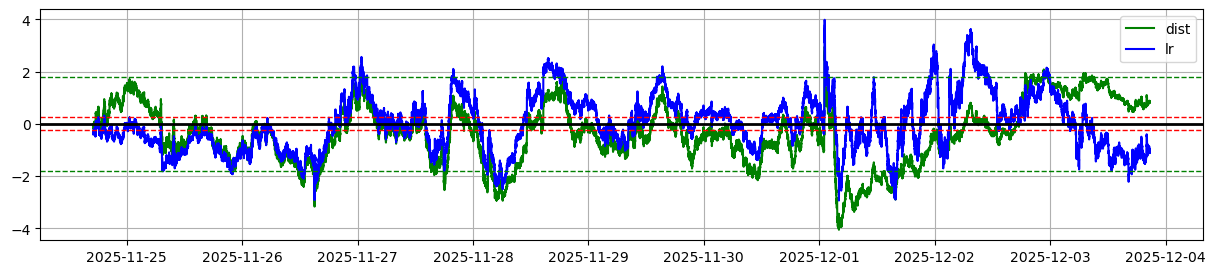

============= S WCT =============
Волатильность. S: 0.0590, WCT: 0.0764. std_ratio: 0.7719
beta_1: 1.046, beta_2: 0.902; tls_beta: 1.058; cointegr: 1; hedge ratio: 0.74
dist. profit:  -2.0; ratio: -0.20; drawdown: -8.53; n_trades: 5; stop losses: 1
  lr. profit:   3.1; ratio:  0.60; drawdown: 0.0; n_trades: 4; stop losses: 0


============= ARB CELO =============
ACTIVE!
Волатильность. ARB: 0.0579, CELO: 0.0553. std_ratio: 1.0477
beta_1: 0.491, beta_2: 1.325; tls_beta: 0.772; cointegr: 0; hedge ratio: 1.96
dist. profit:  10.1; ratio:  2.00; drawdown: 0.0; n_trades: 4; stop losses: 0
  lr. profit:   5.6; ratio:  1.10; drawdown: 0.0; n_trades: 4; stop losses: 0


============= FLOW HBAR =============
ACTIVE!
Волатильность. FLOW: 0.0431, HBAR: 0.0483. std_ratio: 0.8935
beta_1: 0.603, beta_2: 0.990; tls_beta: 1.296; cointegr: 0; hedge ratio: 1.44
dist. profit:   2.1; ratio:  0.30; drawdown: -3.37; n_trades: 6; stop losses: 1
  lr. profit:   3.9; ratio:  0.68; drawdown: -0.96; n_trades: 4; stop losses: 0


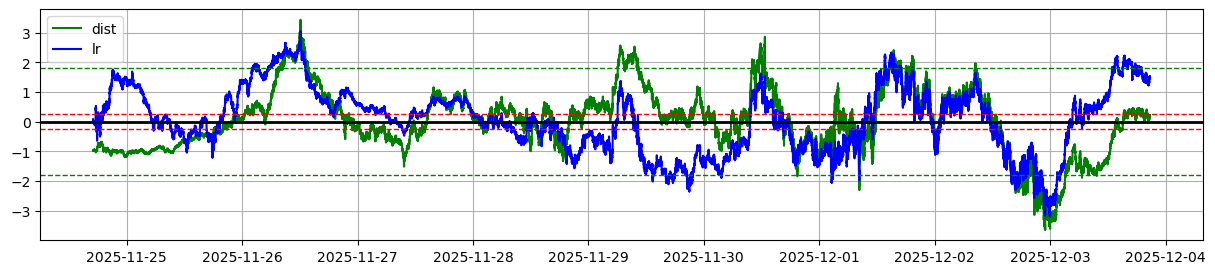

============= CELO FLOW =============
Волатильность. CELO: 0.0553, FLOW: 0.0431. std_ratio: 1.2827
beta_1: 0.903, beta_2: 0.828; tls_beta: 0.850; cointegr: 0; hedge ratio: 0.78
dist. profit:   9.2; ratio:  1.81; drawdown: 0.0; n_trades: 4; stop losses: 0
  lr. profit:   4.1; ratio:  0.57; drawdown: -3.36; n_trades: 4; stop losses: 0


============= AERO MORPHO =============
Волатильность. AERO: 0.0679, MORPHO: 0.0579. std_ratio: 1.1739
beta_1: 0.718, beta_2: 0.807; tls_beta: 0.526; cointegr: 0; hedge ratio: 1.41
dist. profit:   1.9; ratio:  0.38; drawdown: 0.0; n_trades: 2; stop losses: 0
  lr. profit:   2.0; ratio:  0.35; drawdown: -1.25; n_trades: 3; stop losses: 0


============= ARKM WCT =============
Волатильность. ARKM: 0.0603, WCT: 0.0764. std_ratio: 0.7886
beta_1: 0.820, beta_2: 0.855; tls_beta: 1.789; cointegr: 0; hedge ratio: 0.78
dist. profit:  -8.3; ratio: -0.75; drawdown: -10.46; n_trades: 3; stop losses: 1
  lr. profit:   3.5; ratio:  0.59; drawdown: -1.19; n_trades: 5; stop losses: 0


============= ALGO SEI =============
Волатильность. ALGO: 0.0466, SEI: 0.0563. std_ratio: 0.8279
beta_1: 1.403, beta_2: 0.574; tls_beta: 1.481; cointegr: 0; hedge ratio: 0.66
dist. profit:   5.1; ratio:  0.94; drawdown: -0.45; n_trades: 4; stop losses: 0
  lr. profit:  -1.1; ratio: -0.18; drawdown: -2.42; n_trades: 4; stop losses: 1


============= INJ PENDLE =============
ACTIVE!
Волатильность. INJ: 0.0564, PENDLE: 0.0543. std_ratio: 1.0385
beta_1: 0.721, beta_2: 1.213; tls_beta: 1.193; cointegr: 0; hedge ratio: 1.50
dist. profit:   7.7; ratio:  1.51; drawdown: 0.0; n_trades: 3; stop losses: 0
  lr. profit:  16.5; ratio:  2.67; drawdown: -1.66; n_trades: 7; stop losses: 0


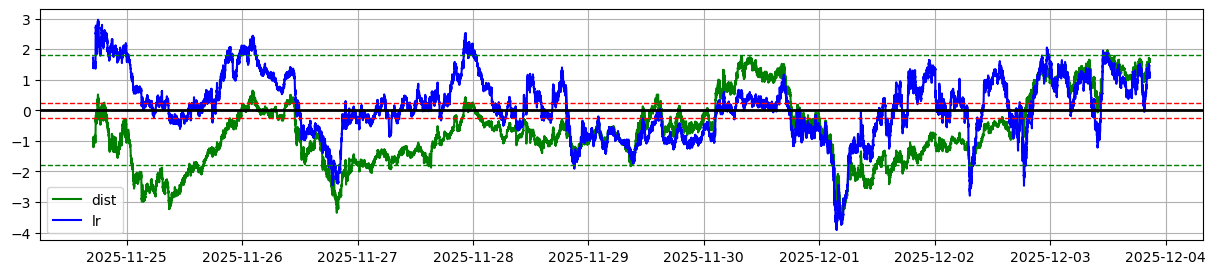

============= ARB XLM =============
Волатильность. ARB: 0.0579, XLM: 0.0421. std_ratio: 1.3760
beta_1: 0.625, beta_2: 1.056; tls_beta: 0.792; cointegr: 0; hedge ratio: 1.38
dist. profit:   6.4; ratio:  1.26; drawdown: 0.0; n_trades: 4; stop losses: 0
  lr. profit:  -0.2; ratio: -0.03; drawdown: -1.11; n_trades: 2; stop losses: 0


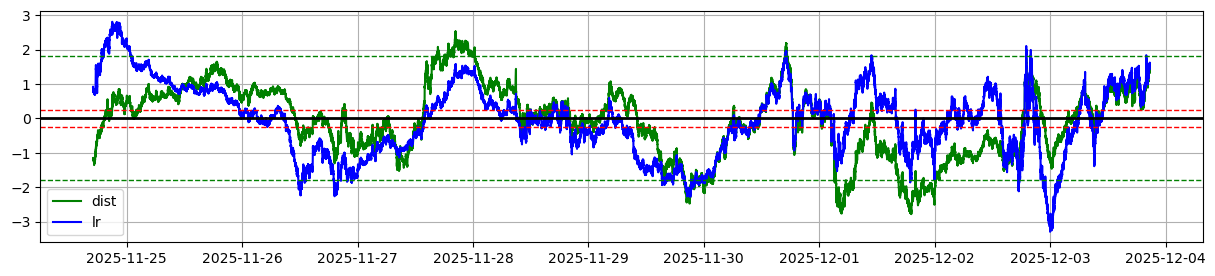

============= APT ATOM =============
ACTIVE!
Волатильность. APT: 0.0467, ATOM: 0.0416. std_ratio: 1.1233
beta_1: 0.845, beta_2: 1.050; tls_beta: 0.890; cointegr: 0; hedge ratio: 1.36
dist. profit:  -2.1; ratio: -0.24; drawdown: -6.27; n_trades: 4; stop losses: 1
  lr. profit:  12.3; ratio:  2.43; drawdown: 0.0; n_trades: 6; stop losses: 0


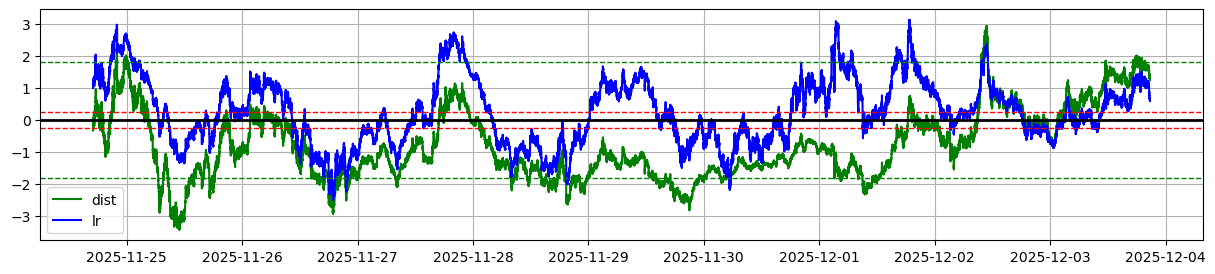

============= ALGO MANTA =============
Волатильность. ALGO: 0.0466, MANTA: 0.0639. std_ratio: 0.7288
beta_1: 0.928, beta_2: 0.662; tls_beta: 1.684; cointegr: 0; hedge ratio: 1.13
dist. profit: -10.8; ratio: -0.98; drawdown: -10.76; n_trades: 3; stop losses: 2
  lr. profit:  -0.2; ratio: -0.03; drawdown: -4.1; n_trades: 6; stop losses: 1


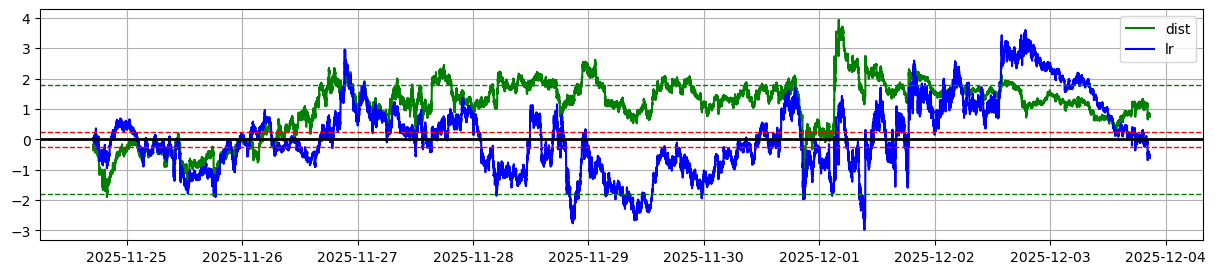

============= DOT PENDLE =============
ACTIVE!
Волатильность. DOT: 0.0444, PENDLE: 0.0543. std_ratio: 0.8182
beta_1: 1.328, beta_2: 0.611; tls_beta: 1.445; cointegr: 0; hedge ratio: 0.73
  lr. profit:  19.1; ratio:  3.51; drawdown: 0.0; n_trades: 5; stop losses: 0


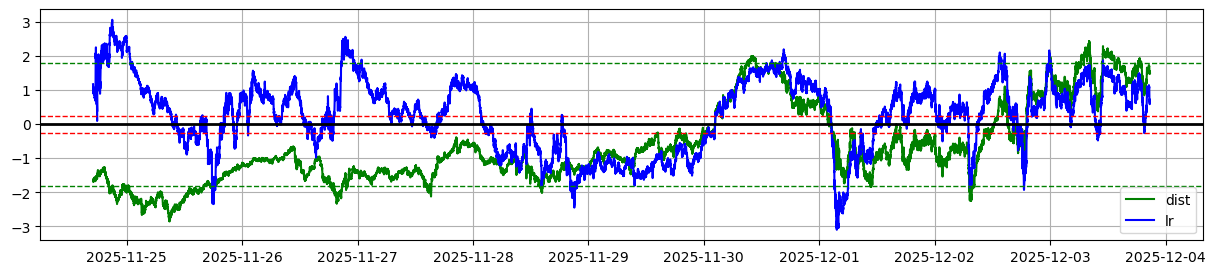

============= APT TON =============
Волатильность. APT: 0.0467, TON: 0.0358. std_ratio: 1.3067
beta_1: 0.821, beta_2: 1.011; tls_beta: 1.122; cointegr: 0; hedge ratio: 1.14
dist. profit:  -9.5; ratio: -0.89; drawdown: -9.5; n_trades: 2; stop losses: 1
  lr. profit:  -0.5; ratio: -0.06; drawdown: -4.02; n_trades: 4; stop losses: 0


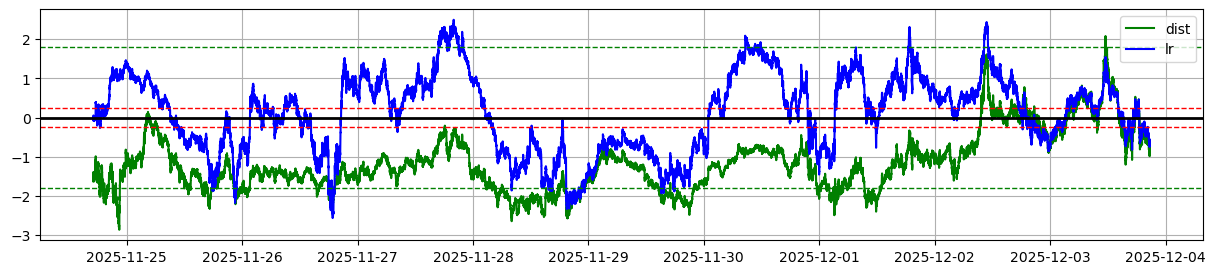

============= DRIFT EIGEN =============
ACTIVE!
Волатильность. DRIFT: 0.0663, EIGEN: 0.0710. std_ratio: 0.9344
beta_1: 1.344, beta_2: 0.616; tls_beta: 0.770; cointegr: 0; hedge ratio: 0.70
dist. profit:   9.4; ratio:  1.74; drawdown: -0.44; n_trades: 4; stop losses: 0
  lr. profit:   8.6; ratio:  1.44; drawdown: -1.4; n_trades: 5; stop losses: 0


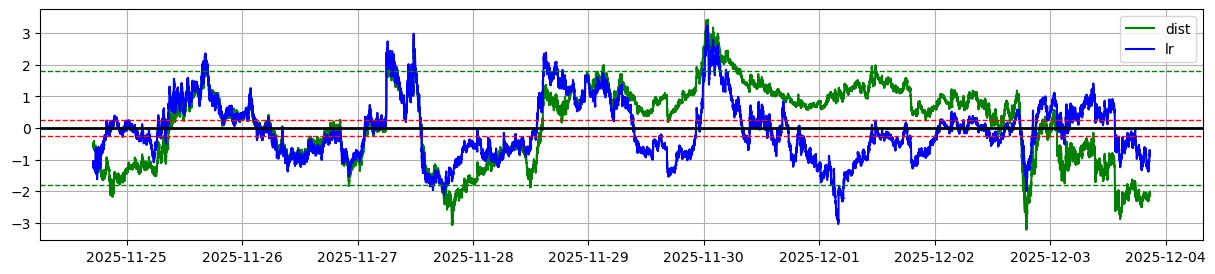

============= ORDI RENDER =============
ACTIVE!
Волатильность. ORDI: 0.0677, RENDER: 0.0539. std_ratio: 1.2560
beta_1: 0.685, beta_2: 1.433; tls_beta: 1.049; cointegr: 1; hedge ratio: 1.37
dist. profit:   1.5; ratio:  0.29; drawdown: 0.0; n_trades: 2; stop losses: 0
  lr. profit:   6.8; ratio:  1.34; drawdown: 0.0; n_trades: 6; stop losses: 0


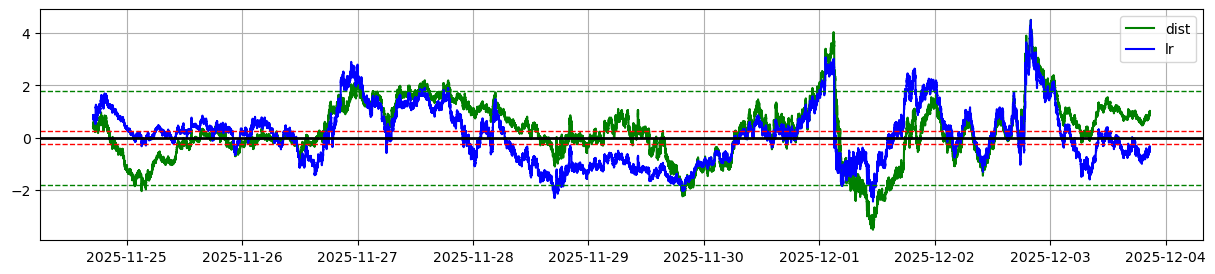

============= RUNE WIF =============
Волатильность. RUNE: 0.0422, WIF: 0.0656. std_ratio: 0.6436
beta_1: 0.879, beta_2: 1.061; tls_beta: 1.309; cointegr: 0; hedge ratio: 1.24
dist. profit:  -7.3; ratio: -0.81; drawdown: -7.27; n_trades: 3; stop losses: 1
  lr. profit:   9.8; ratio:  1.84; drawdown: -0.28; n_trades: 5; stop losses: 0


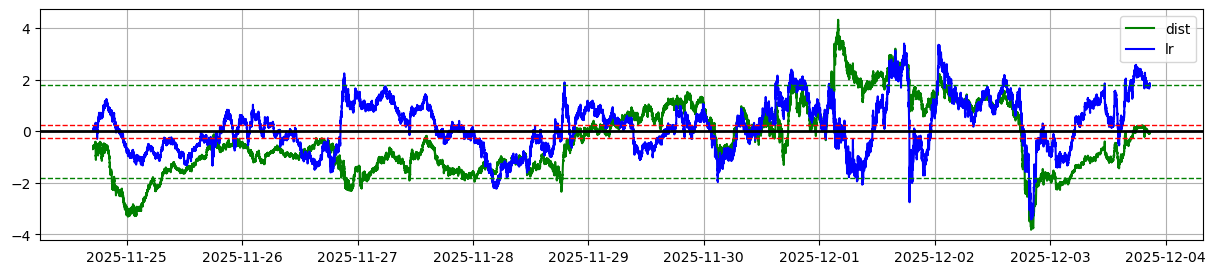

============= SEI XLM =============
Волатильность. SEI: 0.0563, XLM: 0.0421. std_ratio: 1.3366
beta_1: 0.815, beta_2: 0.800; tls_beta: 0.675; cointegr: 0; hedge ratio: 0.97
dist. profit:   3.6; ratio:  0.72; drawdown: 0.0; n_trades: 3; stop losses: 0
  lr. profit:   2.1; ratio:  0.41; drawdown: 0.0; n_trades: 3; stop losses: 0


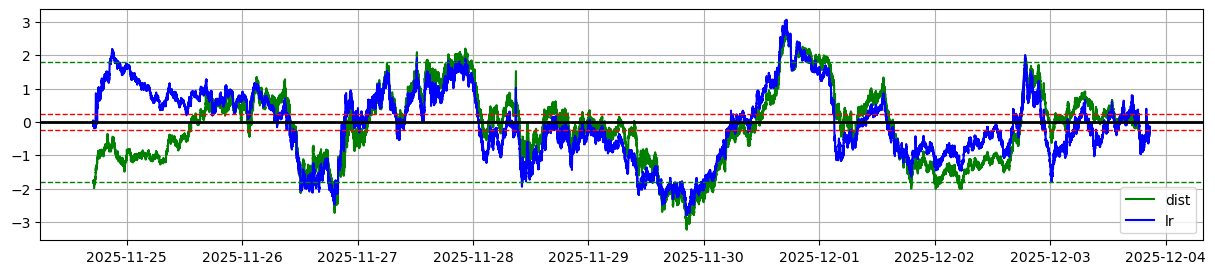

============= STX WCT =============
Волатильность. STX: 0.0471, WCT: 0.0764. std_ratio: 0.6166
beta_1: 0.714, beta_2: 1.191; tls_beta: 1.677; cointegr: 0; hedge ratio: 1.05
dist. profit: -12.6; ratio: -1.04; drawdown: -12.62; n_trades: 4; stop losses: 2
  lr. profit:   0.7; ratio:  0.11; drawdown: -2.21; n_trades: 4; stop losses: 1


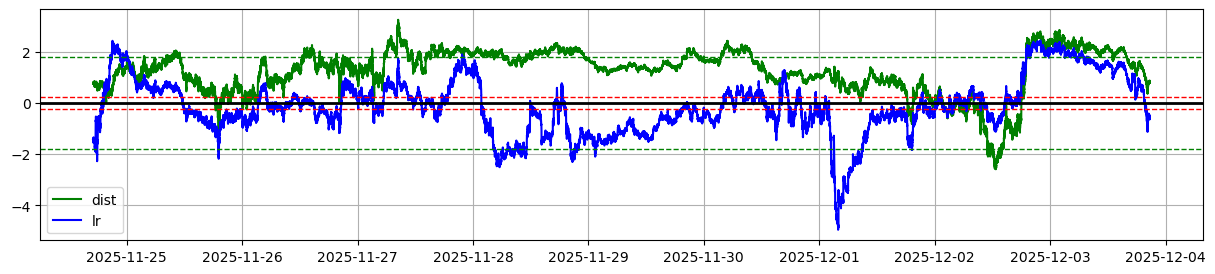

============= APT EGLD =============
Волатильность. APT: 0.0467, EGLD: 0.0488. std_ratio: 0.9587
beta_1: 1.158, beta_2: 0.782; tls_beta: 0.719; cointegr: 0; hedge ratio: 0.96
dist. profit:  -6.3; ratio: -0.64; drawdown: -7.85; n_trades: 3; stop losses: 1
  lr. profit:   6.4; ratio:  1.09; drawdown: -1.44; n_trades: 7; stop losses: 0


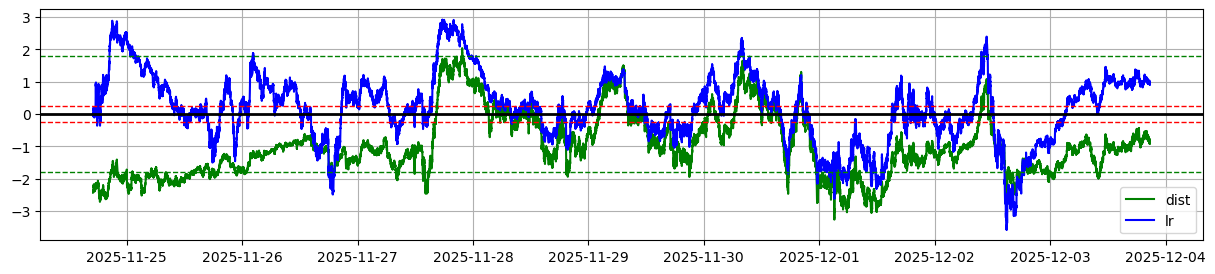

============= JUP S =============
ACTIVE!
Волатильность. JUP: 0.0513, S: 0.0590. std_ratio: 0.8688
beta_1: 0.934, beta_2: 0.773; tls_beta: 1.990; cointegr: 0; hedge ratio: 0.98
dist. profit:  -1.7; ratio: -0.23; drawdown: -4.4; n_trades: 4; stop losses: 1
  lr. profit:   4.7; ratio:  0.81; drawdown: -0.9; n_trades: 3; stop losses: 0


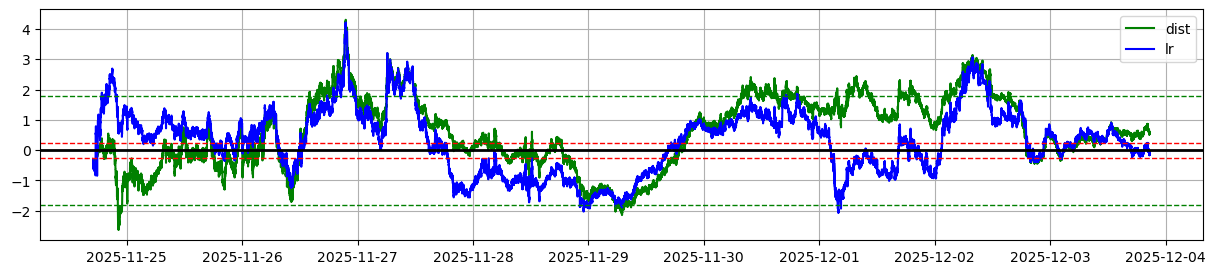

============= TON ZRO =============
ACTIVE!
Волатильность. TON: 0.0358, ZRO: 0.0486. std_ratio: 0.7353
beta_1: 0.482, beta_2: 1.262; tls_beta: 0.691; cointegr: 0; hedge ratio: 2.41
dist. profit:  -2.5; ratio: -0.30; drawdown: -5.45; n_trades: 3; stop losses: 1
  lr. profit:   8.2; ratio:  1.61; drawdown: 0.0; n_trades: 3; stop losses: 0


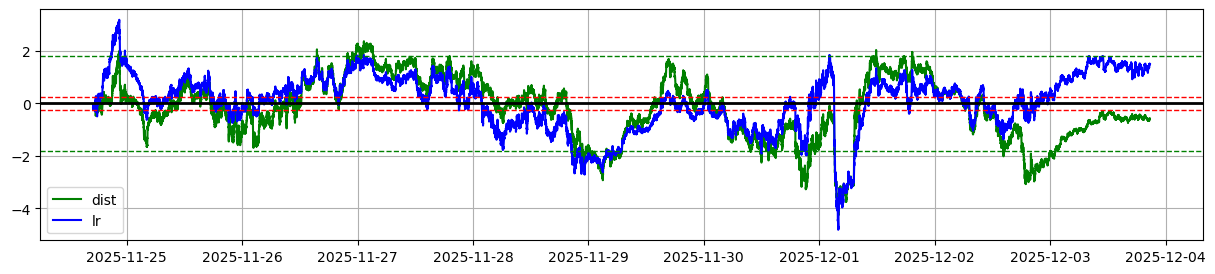

============= CRV DYDX =============
ACTIVE!
Волатильность. CRV: 0.0572, DYDX: 0.0573. std_ratio: 0.9988
beta_1: 0.776, beta_2: 0.961; tls_beta: 1.298; cointegr: 0; hedge ratio: 0.89
dist. profit:   3.4; ratio:  0.67; drawdown: 0.0; n_trades: 3; stop losses: 0
  lr. profit:   5.0; ratio:  0.97; drawdown: -0.15; n_trades: 4; stop losses: 0


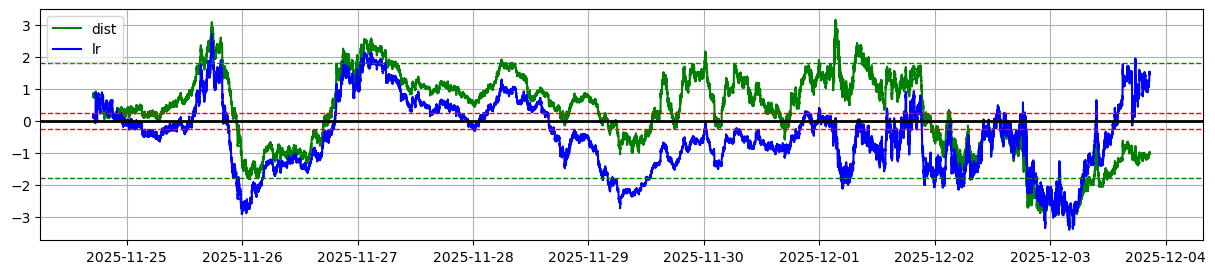

============= MOVE PNUT =============
Волатильность. MOVE: 0.0600, PNUT: 0.0641. std_ratio: 0.9350
beta_1: 1.400, beta_2: 0.621; tls_beta: 0.896; cointegr: 0; hedge ratio: 0.70
dist. profit:   9.5; ratio:  1.84; drawdown: 0.0; n_trades: 4; stop losses: 0
  lr. profit:   7.2; ratio:  1.39; drawdown: 0.0; n_trades: 3; stop losses: 0


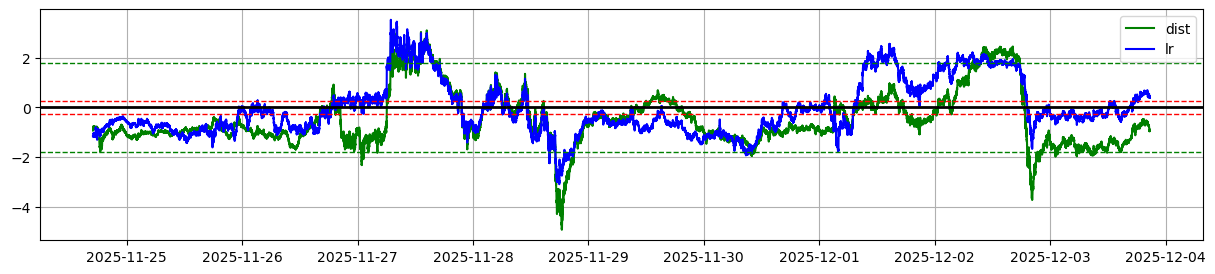

============= ALGO PNUT =============
Волатильность. ALGO: 0.0466, PNUT: 0.0641. std_ratio: 0.7266
beta_1: 1.131, beta_2: 0.515; tls_beta: 2.086; cointegr: 0; hedge ratio: 0.95
dist. profit:  -8.8; ratio: -0.72; drawdown: -12.48; n_trades: 4; stop losses: 2
  lr. profit:   6.7; ratio:  0.90; drawdown: -3.57; n_trades: 4; stop losses: 0


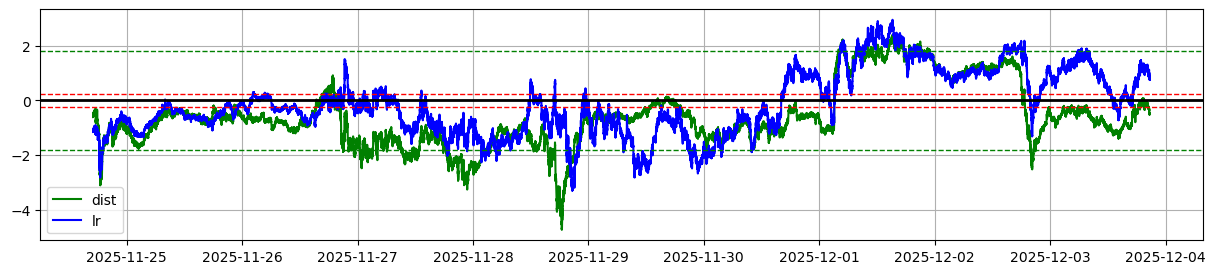

============= AERO LDO =============
ACTIVE!
Волатильность. AERO: 0.0679, LDO: 0.0597. std_ratio: 1.1373
beta_1: 0.857, beta_2: 0.812; tls_beta: 0.977; cointegr: 0; hedge ratio: 1.02
dist. profit:   2.0; ratio:  0.28; drawdown: -3.65; n_trades: 5; stop losses: 1
  lr. profit:   5.0; ratio:  0.98; drawdown: 0.0; n_trades: 3; stop losses: 0


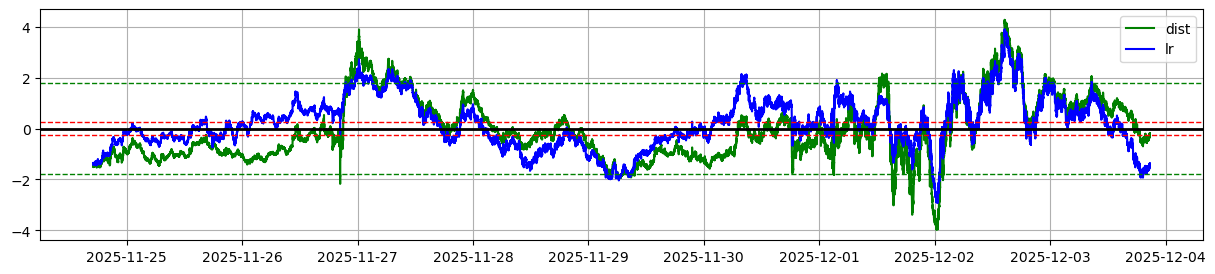

============= WLD XTZ =============
ACTIVE!
Волатильность. WLD: 0.0714, XTZ: 0.0514. std_ratio: 1.3874
beta_1: 0.359, beta_2: 0.914; tls_beta: 0.777; cointegr: 0; hedge ratio: 1.52
dist. profit:   3.6; ratio:  0.71; drawdown: 0.0; n_trades: 5; stop losses: 0
  lr. profit:   6.0; ratio:  1.19; drawdown: 0.0; n_trades: 6; stop losses: 0


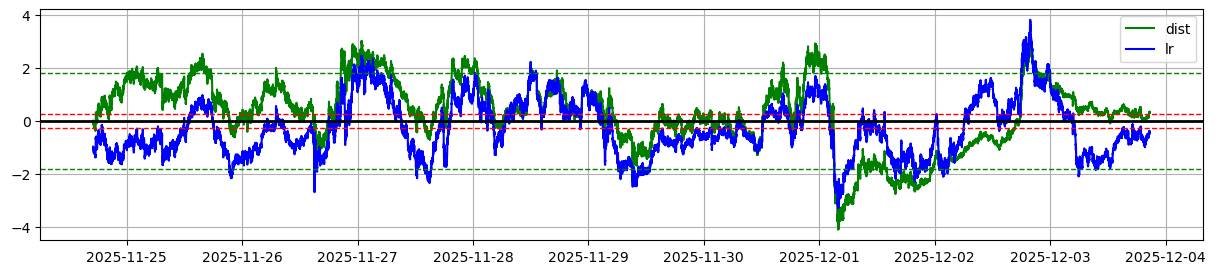

============= DYDX S =============
Волатильность. DYDX: 0.0573, S: 0.0590. std_ratio: 0.9706
beta_1: 0.627, beta_2: 1.305; tls_beta: 1.293; cointegr: 0; hedge ratio: 1.70
dist. profit:   4.1; ratio:  0.81; drawdown: 0.0; n_trades: 5; stop losses: 0
  lr. profit:   3.3; ratio:  0.65; drawdown: 0.0; n_trades: 5; stop losses: 0


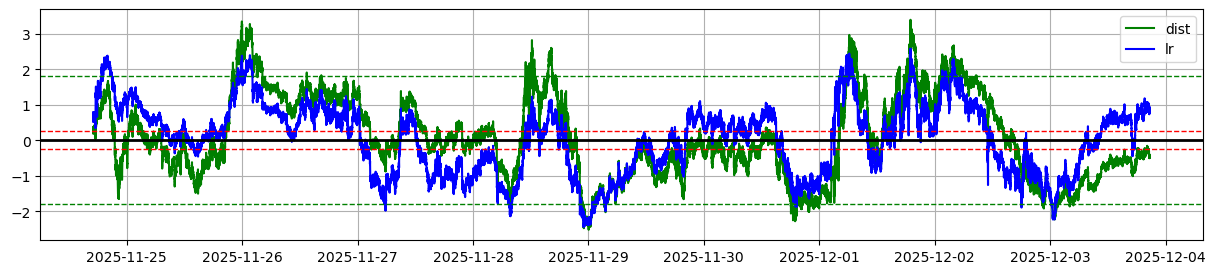

============= MORPHO XRP =============
Волатильность. MORPHO: 0.0579, XRP: 0.0356. std_ratio: 1.6242
beta_1: 0.749, beta_2: 0.702; tls_beta: 0.743; cointegr: 0; hedge ratio: 0.62
dist. profit:   0.3; ratio:  0.04; drawdown: -1.91; n_trades: 5; stop losses: 0
  lr. profit:   0.4; ratio:  0.07; drawdown: -1.93; n_trades: 4; stop losses: 0


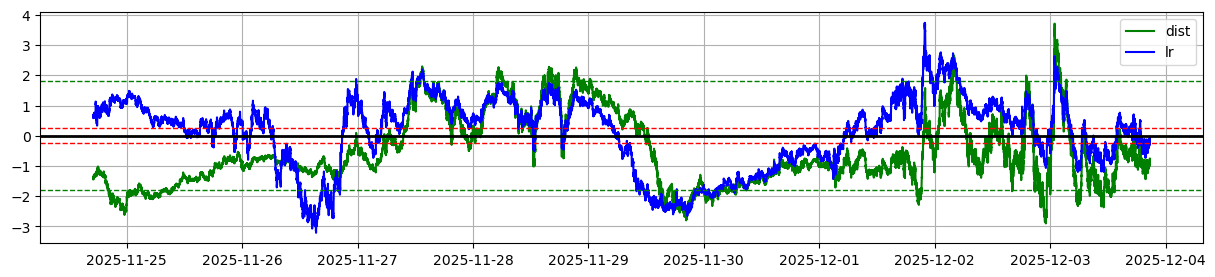

============= AERO ENA =============
ACTIVE!
Волатильность. AERO: 0.0679, ENA: 0.0665. std_ratio: 1.0212
beta_1: 0.823, beta_2: 0.751; tls_beta: 2.193; cointegr: 0; hedge ratio: 0.85
  lr. profit:   7.3; ratio:  1.42; drawdown: 0.0; n_trades: 2; stop losses: 0


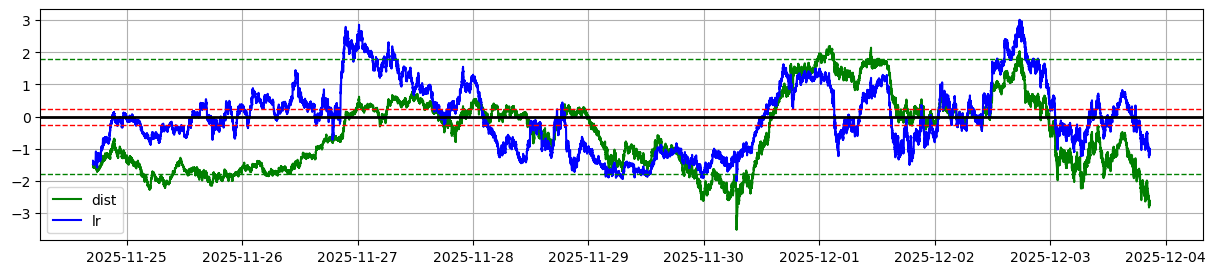

============= HBAR SEI =============
Волатильность. HBAR: 0.0483, SEI: 0.0563. std_ratio: 0.8573
beta_1: 1.277, beta_2: 0.541; tls_beta: 1.416; cointegr: 0; hedge ratio: 0.65
dist. profit:   6.4; ratio:  1.25; drawdown: 0.0; n_trades: 4; stop losses: 0
  lr. profit:   4.5; ratio:  0.77; drawdown: -1.1; n_trades: 4; stop losses: 0


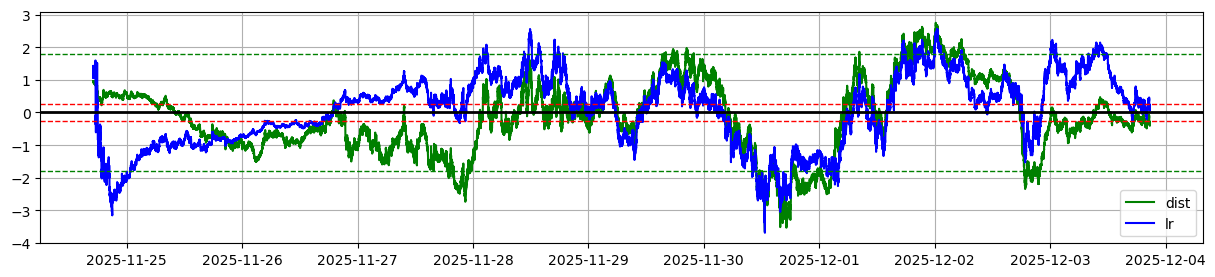

============= LDO PENDLE =============
Волатильность. LDO: 0.0597, PENDLE: 0.0543. std_ratio: 1.1001
beta_1: 1.508, beta_2: 0.526; tls_beta: 0.719; cointegr: 0; hedge ratio: 0.51
dist. profit:  -7.2; ratio: -0.50; drawdown: -13.93; n_trades: 3; stop losses: 1
  lr. profit:   0.7; ratio:  0.10; drawdown: -3.41; n_trades: 3; stop losses: 0


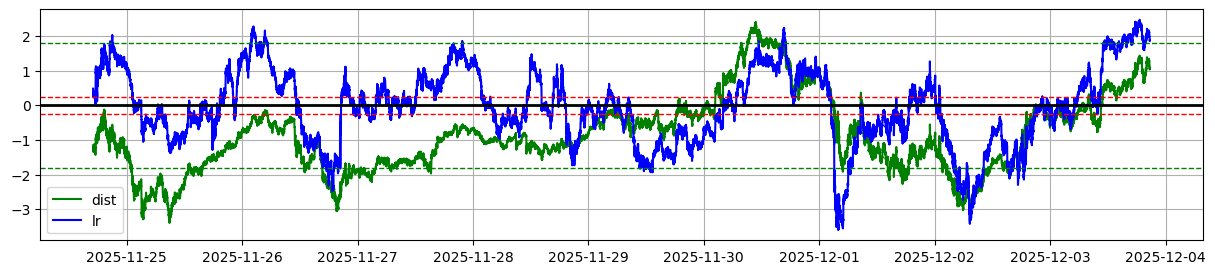

============= ONDO OP =============
ACTIVE!
Волатильность. ONDO: 0.0437, OP: 0.0557. std_ratio: 0.7836
beta_1: 1.042, beta_2: 0.903; tls_beta: 1.428; cointegr: 0; hedge ratio: 0.96
dist. profit:   1.1; ratio:  0.21; drawdown: -0.46; n_trades: 3; stop losses: 0
  lr. profit:   4.2; ratio:  0.83; drawdown: 0.0; n_trades: 5; stop losses: 0


============= CRV LDO =============
ACTIVE!
Волатильность. CRV: 0.0572, LDO: 0.0597. std_ratio: 0.9578
beta_1: 0.868, beta_2: 0.762; tls_beta: 0.755; cointegr: 0; hedge ratio: 1.12
dist. profit:   0.8; ratio:  0.12; drawdown: -2.86; n_trades: 3; stop losses: 0
  lr. profit:   5.1; ratio:  0.84; drawdown: -1.84; n_trades: 6; stop losses: 0


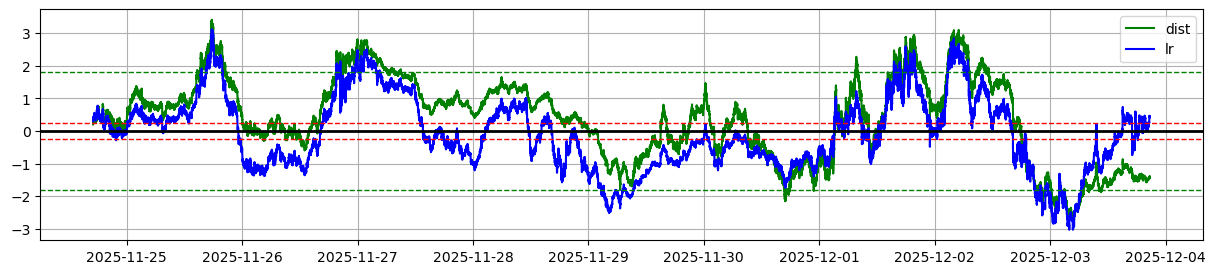

============= ENS ORDI =============
Волатильность. ENS: 0.0464, ORDI: 0.0677. std_ratio: 0.6857
beta_1: 1.019, beta_2: 0.928; tls_beta: 1.559; cointegr: 0; hedge ratio: 1.08
dist. profit:  12.6; ratio:  2.46; drawdown: 0.0; n_trades: 8; stop losses: 0
  lr. profit:   5.3; ratio:  1.02; drawdown: -0.23; n_trades: 7; stop losses: 0


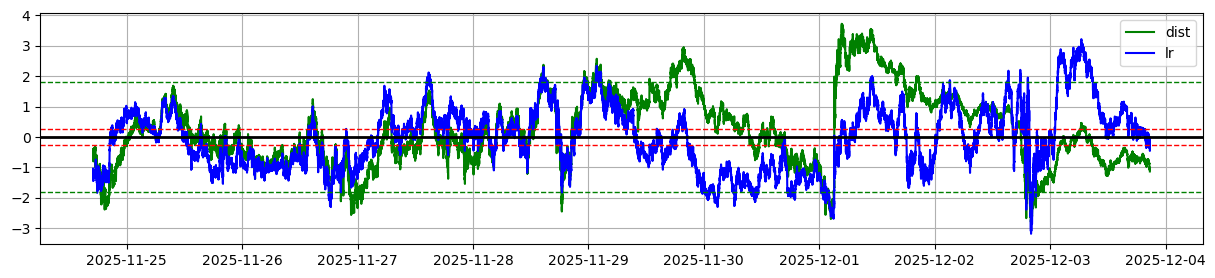

============= EIGEN SPX =============
ACTIVE!
Волатильность. EIGEN: 0.0710, SPX: 0.0806. std_ratio: 0.8813
beta_1: 0.828, beta_2: 0.625; tls_beta: 1.232; cointegr: 0; hedge ratio: 1.21
dist. profit: -11.8; ratio: -0.99; drawdown: -12.16; n_trades: 3; stop losses: 1
  lr. profit:  12.0; ratio:  2.35; drawdown: 0.0; n_trades: 7; stop losses: 0


============= DYDX WCT =============
Волатильность. DYDX: 0.0573, WCT: 0.0764. std_ratio: 0.7493
beta_1: 0.640, beta_2: 1.147; tls_beta: 1.385; cointegr: 0; hedge ratio: 1.26
dist. profit:   3.0; ratio:  0.47; drawdown: -2.03; n_trades: 3; stop losses: 0
  lr. profit:   1.1; ratio:  0.20; drawdown: -0.3; n_trades: 2; stop losses: 0


============= IMX JUP =============
ACTIVE!
Волатильность. IMX: 0.0580, JUP: 0.0513. std_ratio: 1.1316
beta_1: 0.579, beta_2: 0.854; tls_beta: 1.051; cointegr: 0; hedge ratio: 0.73
dist. profit:   3.0; ratio:  0.47; drawdown: -2.32; n_trades: 4; stop losses: 0
  lr. profit:   4.8; ratio:  0.94; drawdown: 0.0; n_trades: 3; stop losses: 0


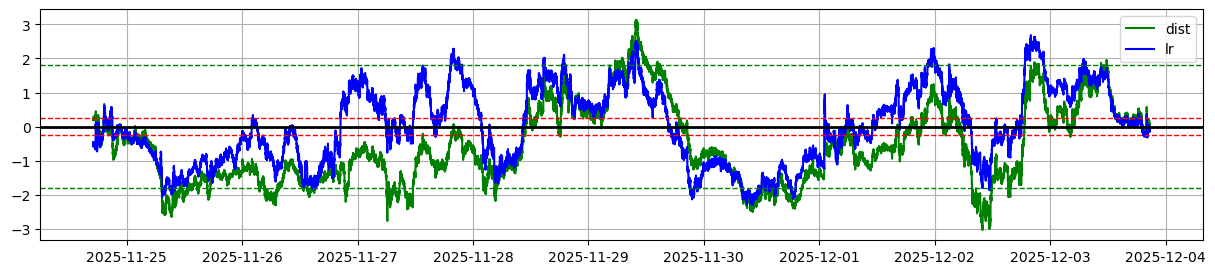

============= S THETA =============
Волатильность. S: 0.0590, THETA: 0.0522. std_ratio: 1.1314
beta_1: 1.350, beta_2: 0.642; tls_beta: 0.597; cointegr: 0; hedge ratio: 0.51
dist. profit:   3.9; ratio:  0.77; drawdown: 0.0; n_trades: 4; stop losses: 0
  lr. profit:   2.6; ratio:  0.41; drawdown: -2.12; n_trades: 5; stop losses: 0


In [47]:
tf = '1h'
wind = 64
in_ = 1.8
out_ = 0.25
dist_in = 0.5
qty_method = 'usdt_neutral'


for token_1, token_2 in all_token_pairs:
    print(f'============= {token_1} {token_2} =============')
    if (token_1, token_2) in current_pairs:
        print('ACTIVE!')
    
    dp_1, dp_2, ps_1, ps_2 = get_coins_info(token_1, token_2)
    stats = pl.read_parquet('./data/pair_selection/all_pairs.parquet').filter(
                (pl.col('coin1') == token_1) & (pl.col('coin2') == token_2))
    try:
        std_1 = stats['std_1'][0]
        std_2 = stats['std_2'][0]
        beta_1 = stats['beta_1'][0]
        beta_2 = stats['beta_2'][0]
        hedge_r = stats['hedge_r'][0]
        coint = stats['coint'][0]
        tls_beta = stats['tls_beta'][0]
    except IndexError:
        print('Нет статистической информации!')
        continue

    print(f'Волатильность. {token_1}: {std_1:.4f}, {token_2}: {std_2:.4f}. std_ratio: {std_1 / std_2:.4f}')
    print(f'beta_1: {beta_1:.3f}, beta_2: {beta_2:.3f}; tls_beta: {tls_beta:.3f}; cointegr: {coint}; hedge ratio: {hedge_r:.2f}')

    file_dist = f'./data/pair_backtest/{token_1}_{token_2}_1h_dist.parquet'
    file_lr = f'./data/pair_backtest/{token_1}_{token_2}_1h_lr.parquet'
    try:
        df_dist = pl.read_parquet(file_dist, low_memory=True, rechunk=True, use_pyarrow=True)
        df_lr = pl.read_parquet(file_lr, low_memory=True, rechunk=True, use_pyarrow=True)
        end_date = df_dist['time'][-1]
    except FileNotFoundError:
        print(f'No Data for {token_1} - {token_2}')
        print()
        continue
        
    metrics = dict()

    
    tdf_dist, trades_df_dist, metrics_dist = run_test(df_dist, wind, in_=in_, out_=out_, 
                                                open_method='reverse_static', dist_in=dist_in, dist_out=0.0)
    tdf_lr, trades_df_lr, metrics_lr = run_test(df_lr, wind, in_=in_, out_=out_, 
                                                open_method='reverse_static', dist_in=dist_in, dist_out=0.0)

    if metrics_dist:
        profit = metrics_dist['profit']
        pr_ratio = metrics_dist['profit_ratio']
        max_drawdown = metrics_dist['max_drawdown']
        n_trades = metrics_dist['n_trades']
        n_sl = metrics_dist['stop_losses']
        print(f'dist. profit: {profit:5.1f}; ratio: {pr_ratio:5.2f}; drawdown: {max_drawdown}; n_trades: {n_trades}; \
stop losses: {n_sl}')

    if metrics_lr:
        profit = metrics_lr['profit']
        pr_ratio = metrics_lr['profit_ratio']
        max_drawdown = metrics_lr['max_drawdown']
        n_trades = metrics_lr['n_trades']
        n_sl = metrics_lr['stop_losses']
        print(f'  lr. profit: {profit:5.1f}; ratio: {pr_ratio:5.2f}; drawdown: {max_drawdown}; n_trades: {n_trades}; \
stop losses: {n_sl}')

    plt.figure(figsize=(15, 3))    
    plt.plot(tdf_dist['time'], tdf_dist['z_score'], c='green', label='dist')
    plt.plot(tdf_lr['time'], tdf_lr['z_score'], c='blue', label='lr')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=2)
    plt.axhline(y=-in_, color='green', linestyle='--', linewidth=1)
    plt.axhline(y=in_, color='green', linestyle='--', linewidth=1)
    plt.axhline(y=-0.25, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=0.25, color='red', linestyle='--', linewidth=1)
    plt.grid()
    plt.legend()
    plt.show()
    

In [ ]:
# Оставляем только лучшие параметры
leverage = 2
tf = '1h'
wind = 96
in_ = 2.5
out_ = 0.25
dist_in = 0
dist_out = 0
spr_method = 'dist'
qty_method = 'usdt_neutral'

metrics_arr = []

for token_1, token_2 in tqdm(all_pairs):
    dp_1 = float(coin_information['bybit_linear'][token_1 + '_USDT']['qty_step'])
    ps_1 = int(coin_information['bybit_linear'][token_1 + '_USDT']['price_scale'])
    dp_2 = float(coin_information['bybit_linear'][token_2 + '_USDT']['qty_step'])
    ps_2 = int(coin_information['bybit_linear'][token_2 + '_USDT']['price_scale'])

    try:
        pair_stats = pairs.filter((pl.col('coin1') == token_1) & (pl.col('coin2') == token_2))
        std_1 = pair_stats['std_1'][0]
        std_2 = pair_stats['std_2'][0]
    except IndexError:
        pair_stats = pairs.filter((pl.col('coin1') == token_2) & (pl.col('coin2') == token_1))
        std_1 = pair_stats['std_2'][0]
        std_2 = pair_stats['std_1'][0]

    filepath = f'./data/pair_backtest/{token_1}_{token_2}_1h_{spr_method}.parquet'
    try:
        df = pl.read_parquet(filepath, low_memory=True, rechunk=True, use_pyarrow=True)
    except FileNotFoundError:
        continue

    end_date = df['time'][-1]
    metrics = dict()

    cols = ['time', 'ts', token_1, f'{token_1}_size', f'{token_1}_bid_price', f'{token_1}_ask_price',
            f'{token_1}_bid_size', f'{token_1}_ask_size', token_2, f'{token_2}_size',
            f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
            f'z_score_{wind}_{tf}']

    tdf = df.select(cols).rename({f'z_score_{wind}_{tf}': 'z_score'}).drop_nulls()

    trades_df = backtest(tdf, token_1, token_2, dp_1, dp_2, ps_1, ps_2,
            thresh_low_in=-in_, thresh_low_out=-out_, thresh_high_in=in_, thresh_high_out=out_,
            long_possible=True, short_possible=True,
            balance=100, order_size=50, qty_method=qty_method, std_1=std_1, std_2=std_2,
            fee_rate=0.00055, stop_loss_std=8.0, sl_method='leave',
            sl_seconds = 60, leverage=leverage, dist_in=0, dist_out=0,
            verbose=0)

    if trades_df.height > 1:
        metrics = analyze_strategy(trades_df, start_date=valid_time, end_date=end_date, initial_balance=100.0)

    if metrics:
        metrics_arr.append({
            'token_1': token_1, 'token_2': token_2, 'tf': tf, 'wind': wind,
            'thresh_in': in_, 'thresh_out': out_, 'dist_in': dist_in, 'dist_out': dist_out,
            'n_trades': metrics['n_trades'], 'duration_avg': metrics['duration_avg'],
            'stop_losses': metrics['stop_losses'], 'liquidations': metrics['liquidations'],
            'profit': metrics['profit'], 'profit_ratio': metrics['profit_ratio'],
            'max_profit': metrics['max_profit'], 'max_drawdown': metrics['max_drawdown'],
            'max_loss': metrics['max_loss'], 'avg_profit': metrics['avg_profit'],
            'profit_std': metrics['profit_std']})

best_output = pl.DataFrame(metrics_arr).sort(by='profit', descending=True)

In [ ]:
print(f'sum_profit: {best_output['profit'].sum():.1f}; avg profit: {best_output['profit'].mean():.2f}; \
pr ratio: {best_output['profit_ratio'].mean():.2f}')

In [ ]:
# sum_profit: 244.8; avg profit: 8.44; pr ratio: 1.58

In [ ]:
best_output.height

In [ ]:
best_res = best_output.group_by('token_1', 'token_2').agg(
            pl.col('profit').sum().round(2).alias('profit'),
            pl.col('max_loss').min().round(2).alias('max_loss'),
            pl.col('max_drawdown').mean().round(2).alias('avg_drawdown'),
            pl.col('max_drawdown').min().round(2).alias('max_drawdown'),
            pl.col('duration_avg').mean().alias('duration_avg'),
            pl.col('profit_ratio').mean().round(2).alias('profit_ratio'),
            pl.col('n_trades').mean().cast(pl.Int64).alias('n_trades'),
        ).filter(
            pl.col('profit') > 2
        ).sort('profit_ratio', descending=True)
best_res[0:10]

In [ ]:
best_res.select(
    'token_1', 'token_2', 'profit', 'profit_ratio', 'max_loss', 'max_drawdown', 'duration_avg', 'n_trades'
).write_parquet(f'./data/pair_selection/best_params_{spr_method}_result.parquet')

#### Отбор монет

In [ ]:
method = 'dist'
pairs = pl.read_parquet('./data/pair_selection/curr_pairs.parquet')

common_params = pl.read_parquet(f'./data/pair_selection/common_params_{method}_result.parquet')
common_params = common_params.rename({'token_1': 'coin1', 'token_2': 'coin2', 'avg_profit': 'avg_pr_all', 'profit_std': 'pr_std_all',
                                     'max_loss': 'loss_all', 'avg_drawdown': 'avg_drdn_all', 'max_drawdown': 'max_drdn_all',
                                     'avg_duration': 'dur_all', 'avg_pr_ratio': 'pr_rat_all', 'avg_trades': 'trades_all'})

best_params = pl.read_parquet(f'./data/pair_selection/best_params_{method}_result.parquet')
best_params = best_params.rename({'token_1': 'coin1', 'token_2': 'coin2', 'profit': 'pr_best', 'profit_ratio': 'pr_rat_best',
                                     'max_loss': 'loss_best', 'max_drawdown': 'max_drdn_best',
                                     'duration_avg': 'dur_best', 'n_trades': 'trades_best'})

pairs = pairs.with_columns(
    pl.col('dist').round(2),
    pl.col('std').round(2),
    pl.col('corr').round(2),
    pl.col('pv_1').round(2),
    pl.col('pv_2').round(2),
)

pairs = pairs.join(best_params, on=['coin1', 'coin2'])

cols_to_rename = {'pr_best': 'profit', 'pr_rat_best': 'profit_ratio', 'loss_best': 'max_loss', 'max_drdn_best': 'max_drn',
                 'dur_best': 'avg_duration', 'trades_best': 'trades'}
pairs = pairs.rename(cols_to_rename).sort('profit_ratio', descending=True)

pairs = pairs.filter(
    (abs(pl.col('beta_1') - pl.col('beta_2')) < 1.4) & (pl.col('profit') > 2) & (pl.col('dist') < 2.8) & (pl.col('corr') > 0.75)
    & (pl.col('pv_1') < 0.05) & (pl.col('pv_2') < 0.05)
).sort(by='profit', descending=True)

In [ ]:
pairs#[0:30]

In [ ]:
pairs.filter(pl.col('coin1') == 'GMT')

In [ ]:
# Жадный метод
used_tokens = []
trade_pairs_list = []
total_profit = 0

for row in pairs.iter_rows(named=True):
    t1 = row['coin1']
    t2 = row['coin2']
    profit = row['profit']
    
    if t1 in used_tokens or t2 in used_tokens:
        continue

    trade_pairs_list.append((t1, t2))
    used_tokens.append(t1)
    used_tokens.append(t2)
    total_profit += profit
    print(t1, t2, profit)
print('Общий профит:', round(total_profit, 1))

In [ ]:
import networkx as nx

In [ ]:
df = pairs.filter(
    abs(pl.col('beta_1') - pl.col('beta_2')) < 1.8
).with_columns([
        pl.when(pl.col("coin1") < pl.col("coin2")).then(pl.col("coin1")).otherwise(pl.col("coin2")).alias("a"),
        pl.when(pl.col("coin1") < pl.col("coin2")).then(pl.col("coin2")).otherwise(pl.col("coin1")).alias("b"),
])

In [ ]:
edges = df.group_by(["a","b"]).agg(
    pl.max("profit").alias("weight")
)

In [ ]:
G = nx.Graph()
for row in edges.to_dicts():
    # row: {"a": "BLUR", "b":"MANTA", "weight": 28.33}
    G.add_edge(row["a"], row["b"], weight=float(row["weight"]))

In [ ]:
matching = nx.max_weight_matching(G, maxcardinality=False, weight="weight")

In [ ]:
matched_rows = []
total = 0.0
for u, v in matching:
    w = G[u][v]["weight"]
    matched_rows.append({"coin1": u, "coin2": v, "profit": w})
    total += w

In [ ]:
matched_df = pl.DataFrame(matched_rows)

In [ ]:
print("Matched pairs:")
print(matched_df[:])
print(f"Total profit: {total:.2f}")

In [ ]:
trading_history = db_manager.get_table('trading_history', df_type='polars')

res_df = trading_history.group_by('token_1', 'token_2').agg(
        pl.col('profit').sum().round(2),
        pl.col('profit').min().round(2).alias('min_profit'),
        pl.col('profit').max().round(2).alias('max_profit'),
        (pl.col('profit').sum() / pl.col('profit').len()).round(2).alias('avg_profit'),
        pl.col('profit').len().alias('n_trades'),
    
    ).sort(by='profit', descending=True)

res_df = res_df.join(pairs, left_on=('token_1', 'token_2'), right_on=('coin1', 'coin2')).sort('profit', descending=True)
# res_df = res_df.rename({'dist': 'spr_dist', 'std': 'spr_std'})
res_df.shape

In [ ]:
res_df

In [ ]:
cols = ['token_1', 'token_2', 'profit', 'min_profit', 'max_profit', 'avg_profit', 'n_trades', 'spr_dist', 'spr_std', 'std_1', 'std_2',
       'dist_1', 'dist_2', 'corr', 'pv_1', 'pv_2', 'avg_pr_all', 'pr_std_all', 'loss_all', 'avg_drdn_all', 'max_drdn_all', 'pr_rat_all',
       'pr_best', 'pr_rat_best', 'loss_best', 'max_drdn_best']

In [ ]:
res_df.select(cols).head(10)

In [ ]:
res_df.select(cols).tail(5)

In [ ]:
pairs.filter((pl.col('coin1') == 'CELO') & (pl.col('coin2') == 'IMX'))